# Generative Models

## GANs & VAE

### HW4

**Full Name:** amir khazama

**SID:** 99105391

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [5]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [6]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [7]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.12MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.41MB/s]


In [8]:
num_threads = 2
batch_size = 128


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_threads)

In [9]:
A = next(iter(train_loader))
A[0].shape

torch.Size([128, 1, 28, 28])

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        # TODO
        # Define your variational encoder layers.
        ##########################################################
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)


    def forward(self, x):

        ##########################################################
        # TODO
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        ##########################################################
        x = x.view(x.size(0), -1)  # Flatten the image
        h = F.relu(self.fc1(x))
        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        ##############################
        # TODO
        # Define your decoder layers.
        ##############################

        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        ########################################
        # TODO
        # Decode the latent vector `z` to images.
        ########################################
        h = F.relu(self.fc1(z))
        x = torch.sigmoid(self.fc_out(h))  # Output in [0,1]
        return x

In [11]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)


    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std


    def forward(self, x):
        ##########################################################
        # TODO
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the eeparameterization trick to ensure gradient flow.
        ##########################################################
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        image = self.decoder(z)


        return image, z_mean, z_log_var

In [12]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

In [13]:
def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model = VAE(input_dim, hidden_dim, latent_dim).to(DEVICE)

    def criterion(x, x_reconstructed, mean, log_var):
        x_flat = x.view(-1, 784)
        recon_flat = x_reconstructed.view(-1, 784)
        recon_loss = torch.nn.functional.mse_loss(recon_flat, x_flat, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return recon_loss + kl_div

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:

                ###############################################
                # TODO
                # Calculate the loss.
                # (optional) Use the KL divergence loss to normalize the
                # output distribution of decoder.
                ###############################################
                images, _ = data
                images = images.to(DEVICE)

                optimizer.zero_grad()
                x_reconstructed, z_mean, z_log_var = model(images)
                loss = criterion(images, x_reconstructed, z_mean, z_log_var)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                pbar.set_postfix(loss=loss.item())

            print('Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))

        # TODO
        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        recon_image = reconstruct_images(model, sample_images)

        # Plot first 4 original and reconstructed images
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(2, 4, figsize=(8, 4))
        for i in range(4):
            axs[0, i].imshow(sample_images[i].cpu().squeeze(), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon_image[i].view(1, 28, 28).cpu().squeeze(), cmap='gray')
            axs[1, i].axis('off')
        plt.suptitle(f'Epoch {epoch + 1}')
        plt.show()

    return model

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 77.0819


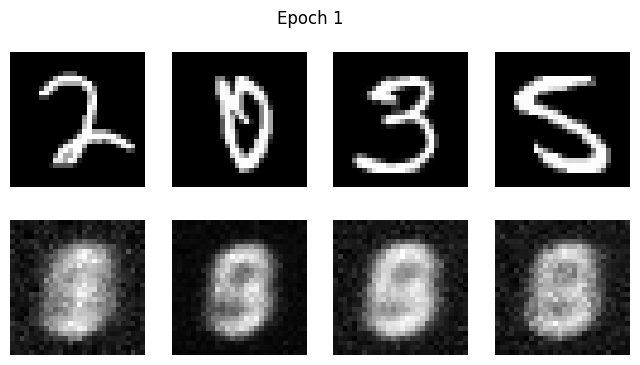

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 51.6309


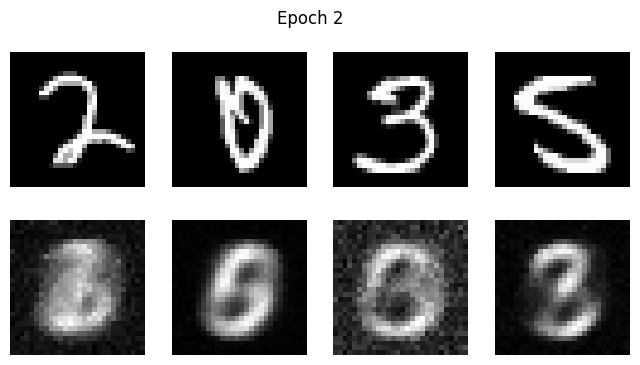

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 45.4608


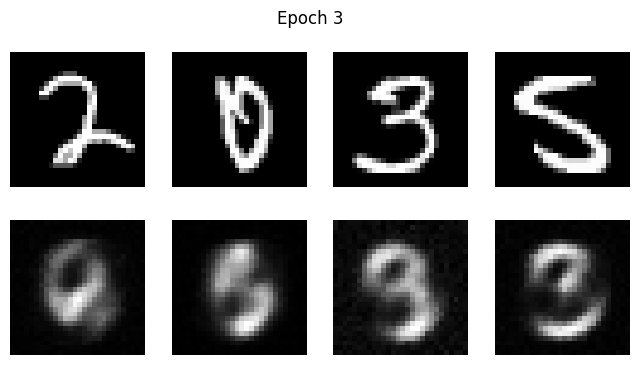

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 42.5214


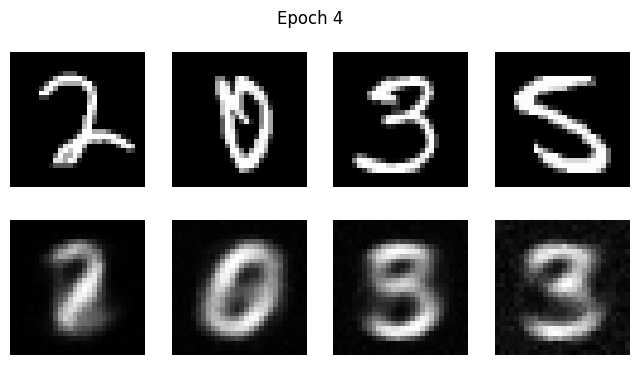

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 40.6069


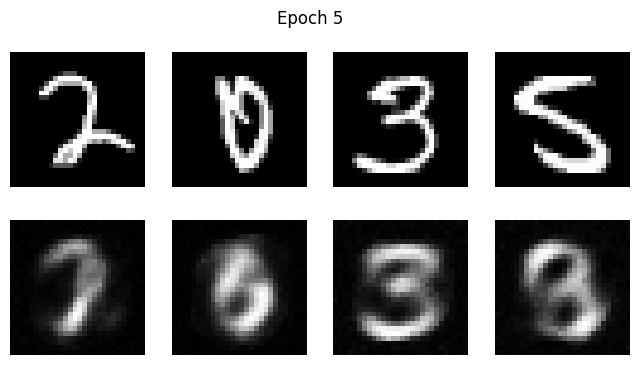

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 39.2299


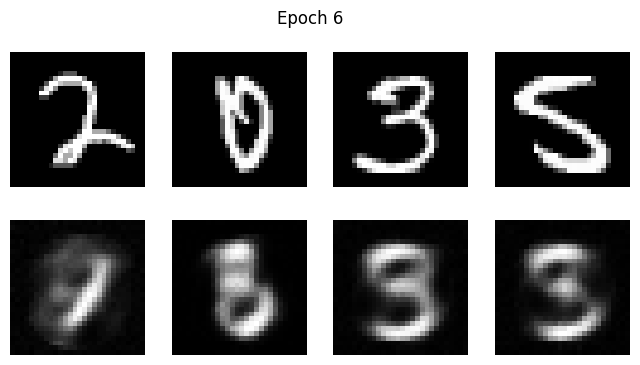

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 38.1064


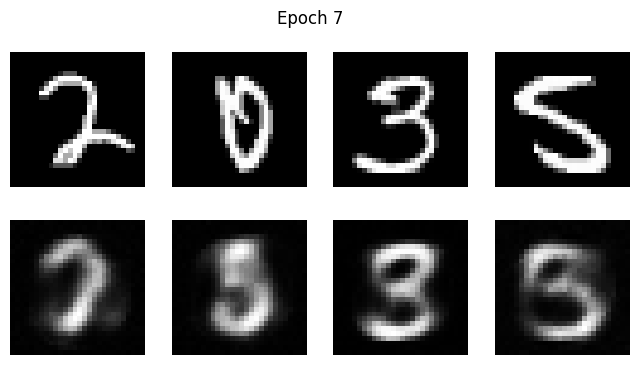

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 37.2447


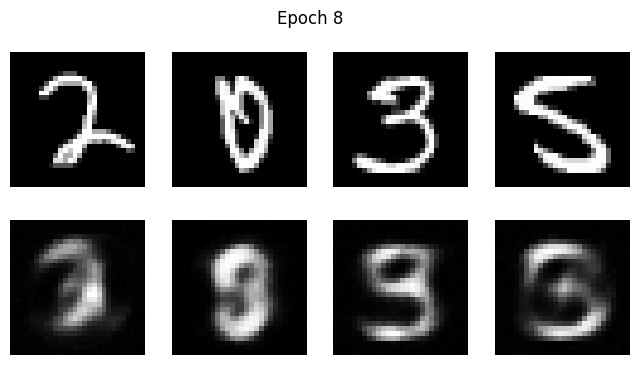

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 36.5411


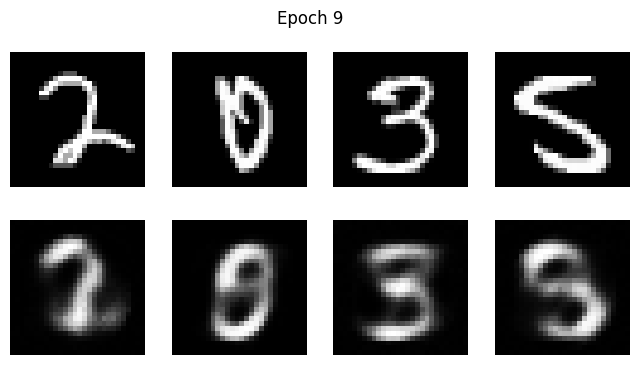

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 35.9883


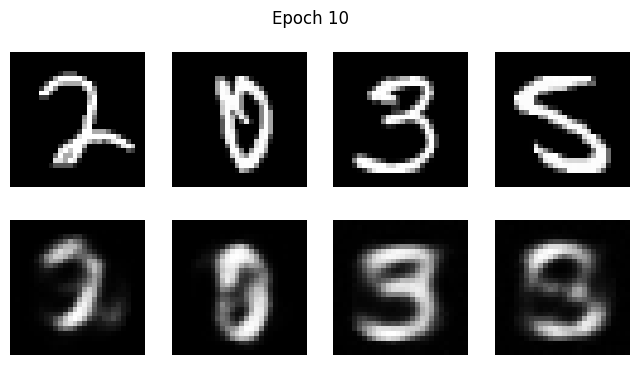

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 35.5111


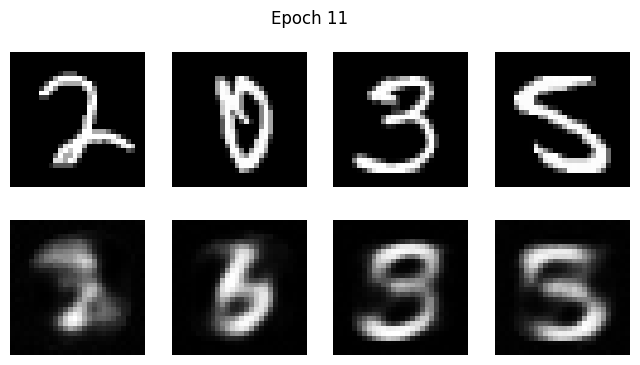

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 35.1092


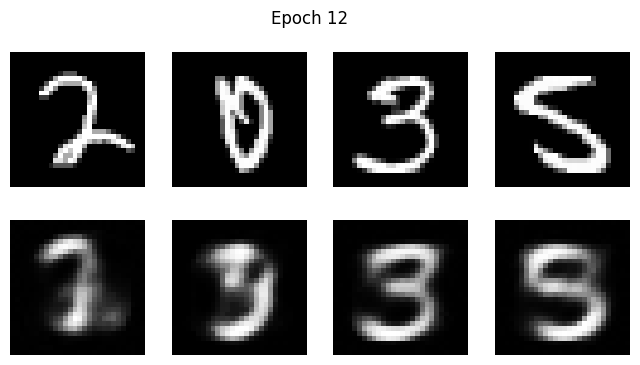

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 34.6881


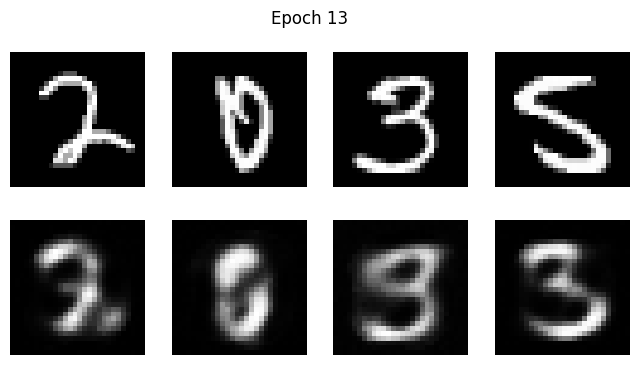

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 34.4284


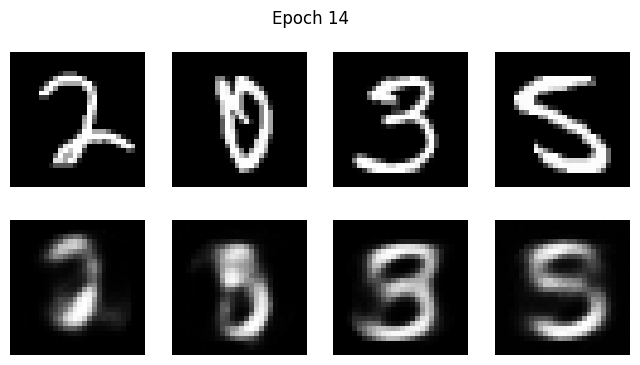

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 34.1406


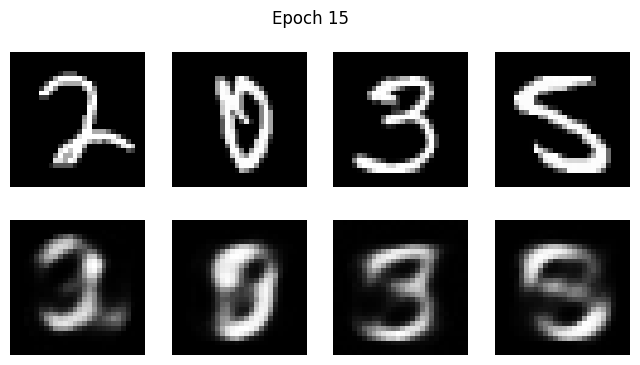

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 33.9247


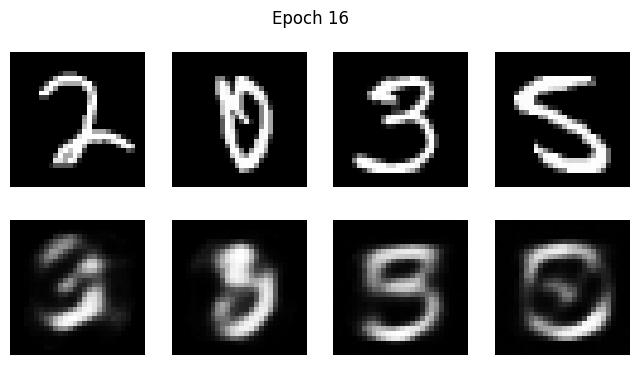

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 33.6922


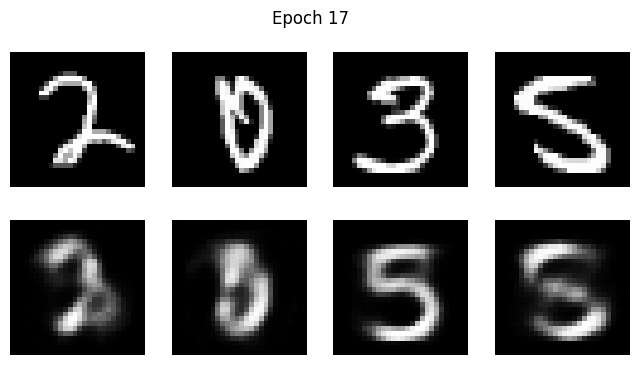

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 33.5007


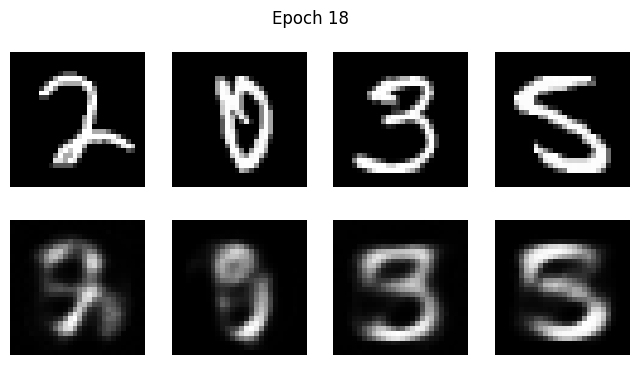

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 33.3446


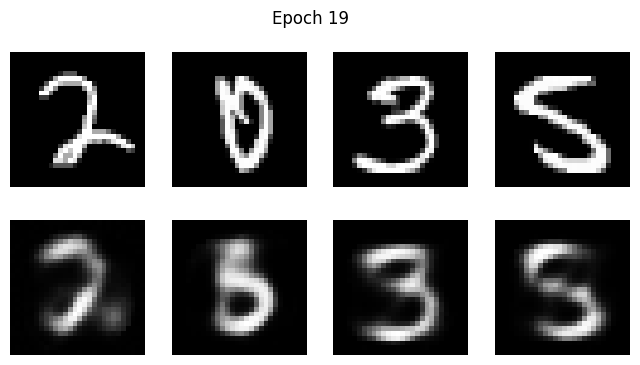

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 33.1671


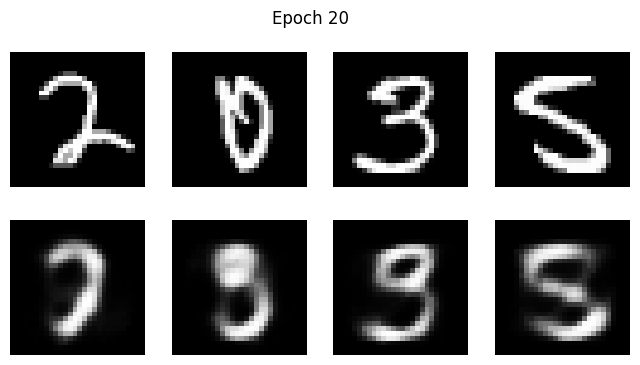

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 33.0080


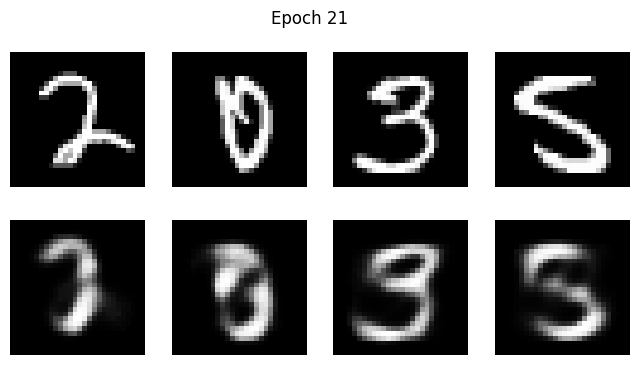

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 32.8564


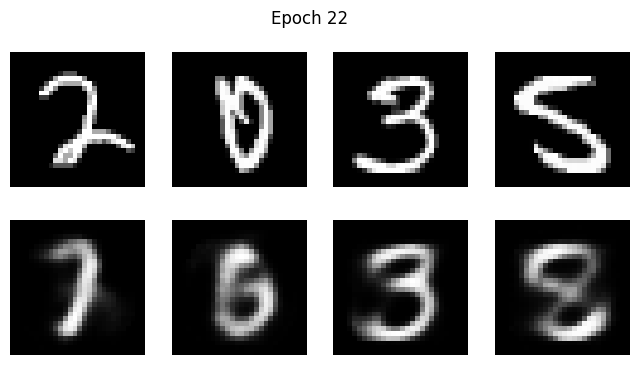

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 32.7544


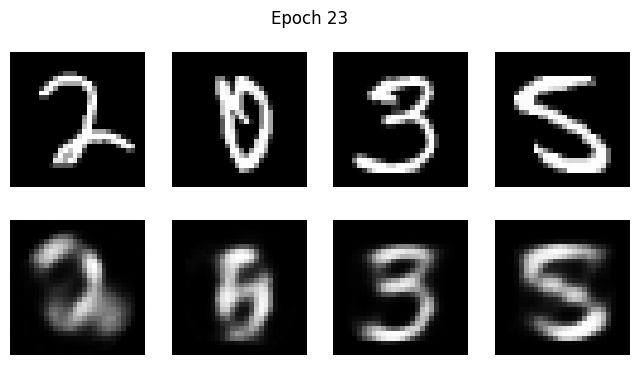

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 32.5884


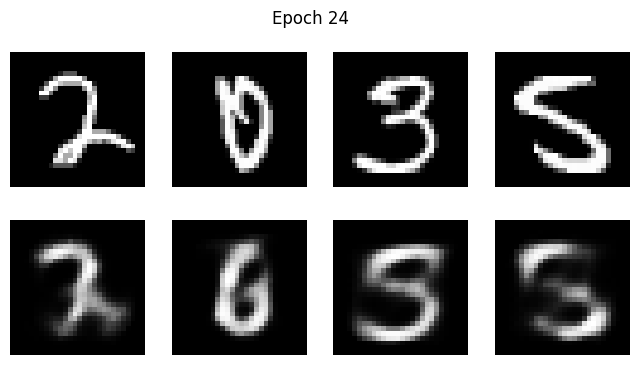

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 32.4984


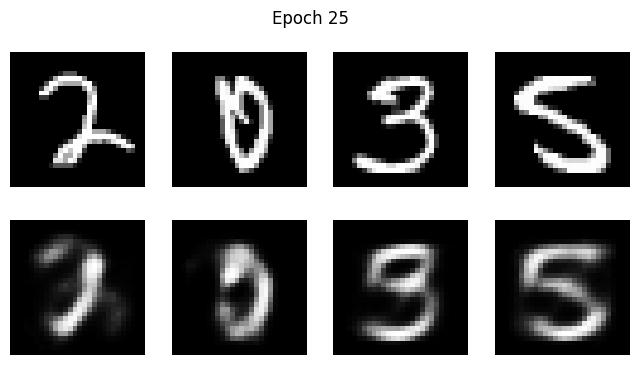

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 32.3901


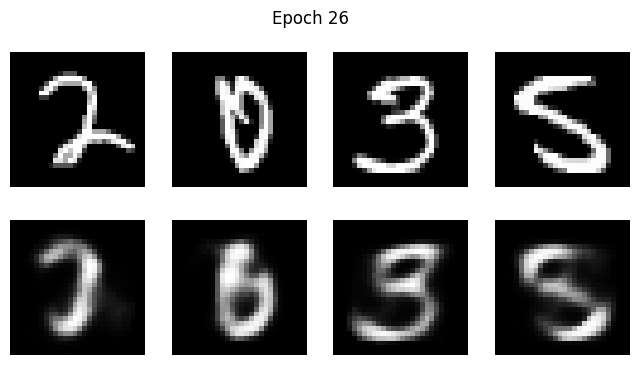

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 32.3074


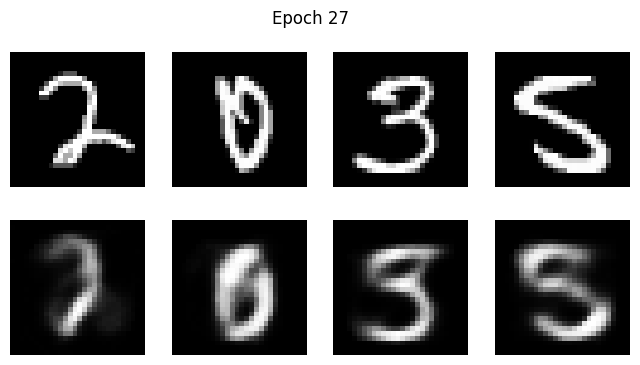

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 32.1861


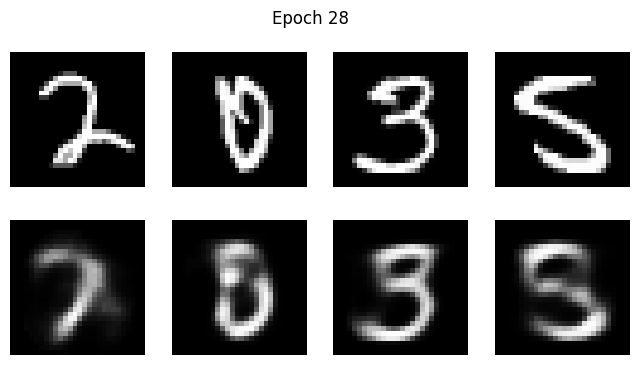

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 32.1315


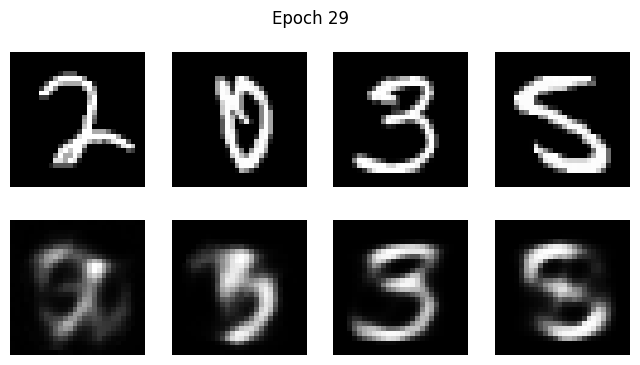

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 32.0358


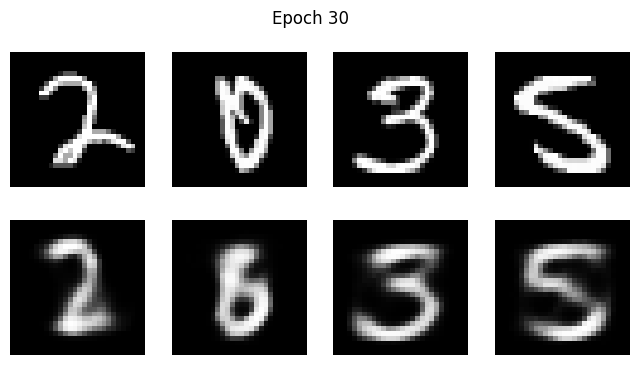

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.9643


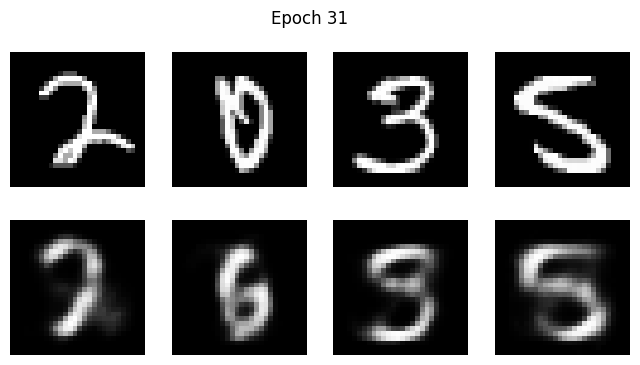

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.8781


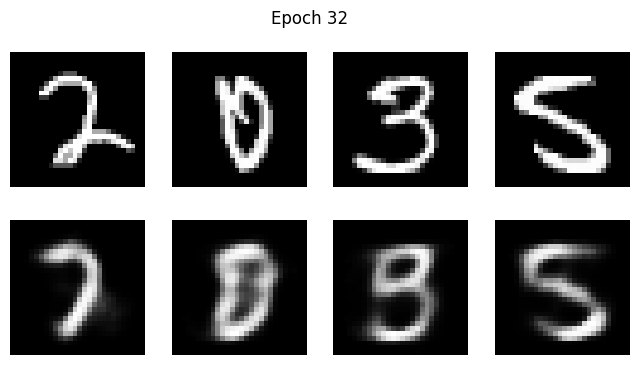

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.8217


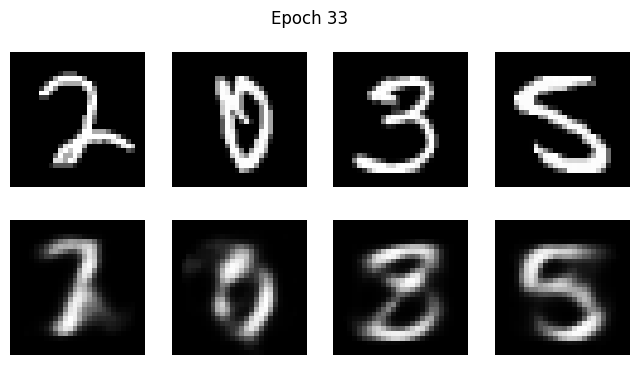

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.7492


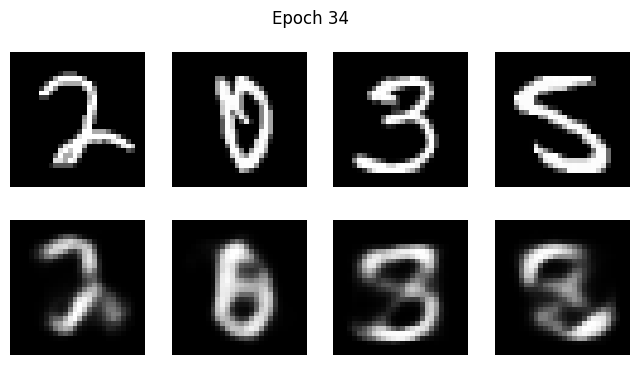

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.6969


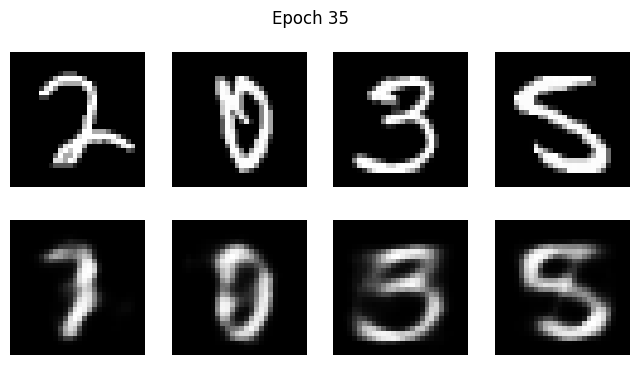

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.6627


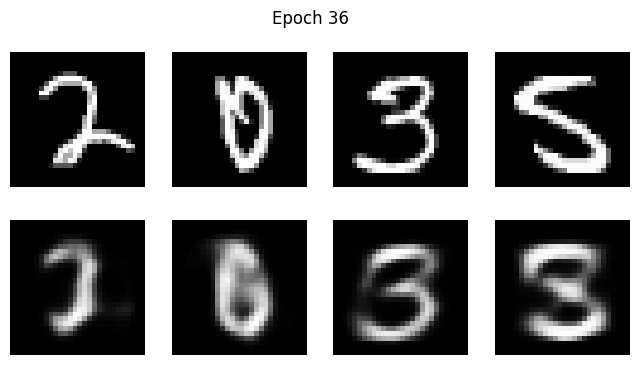

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.5817


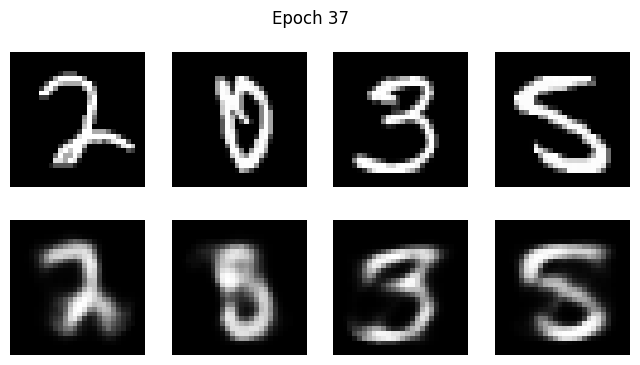

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.5146


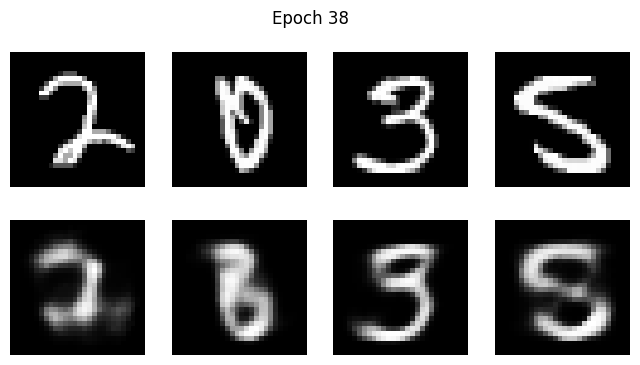

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.4706


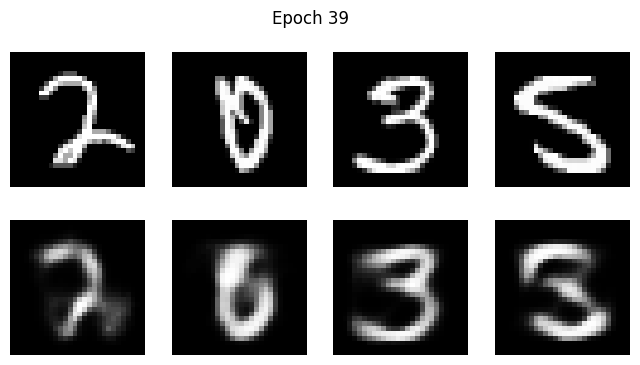

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.3859


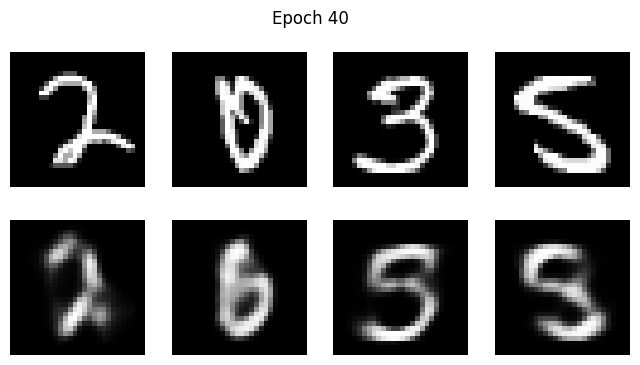

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.3247


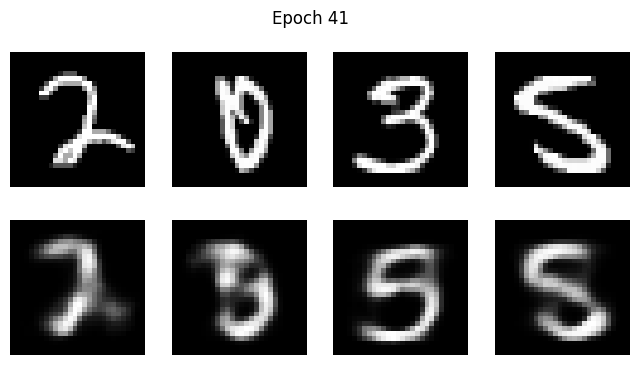

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.3285


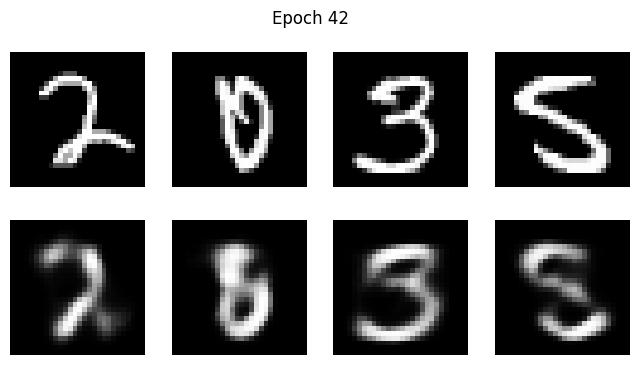

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.3275


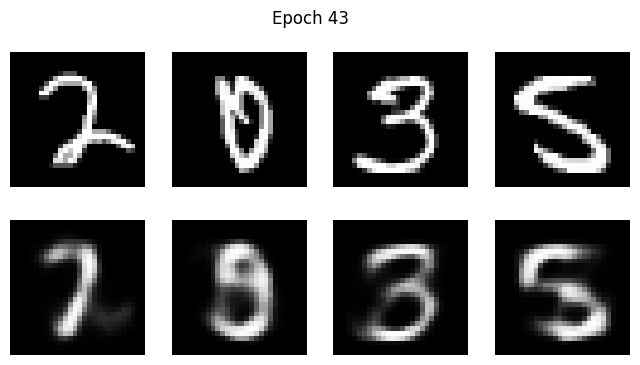

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.2092


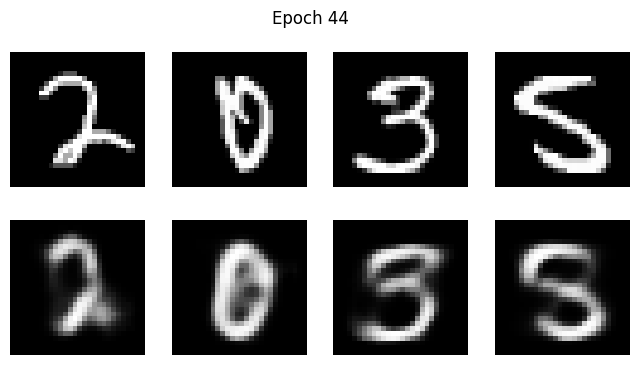

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.1841


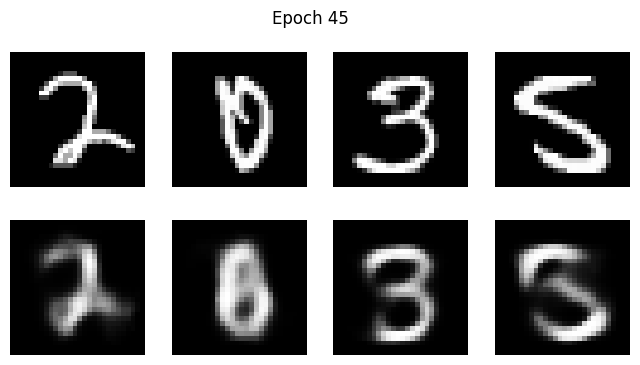

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.1660


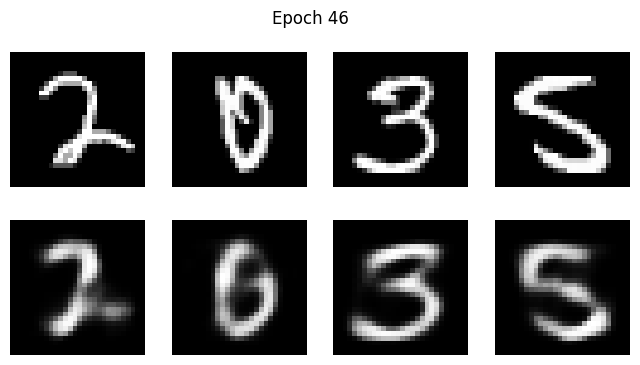

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.1387


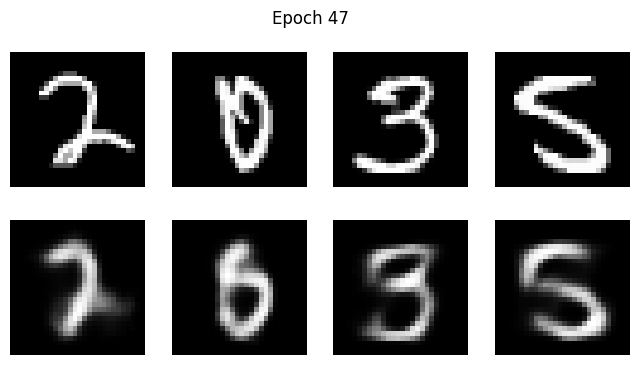

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.0824


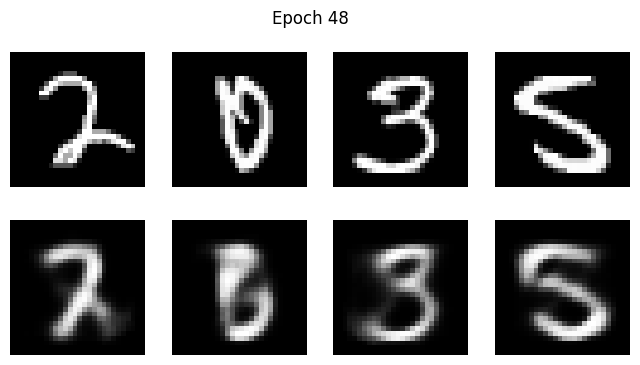

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 31.0524


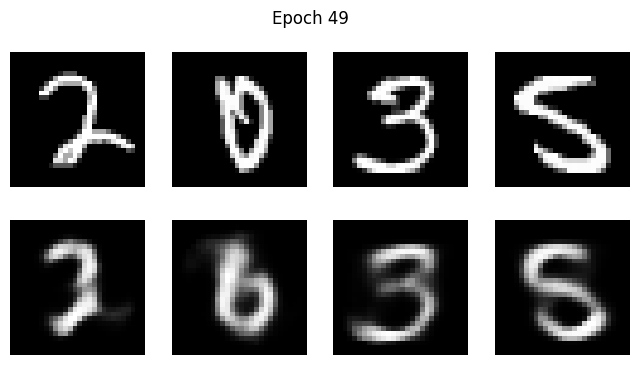

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.9957


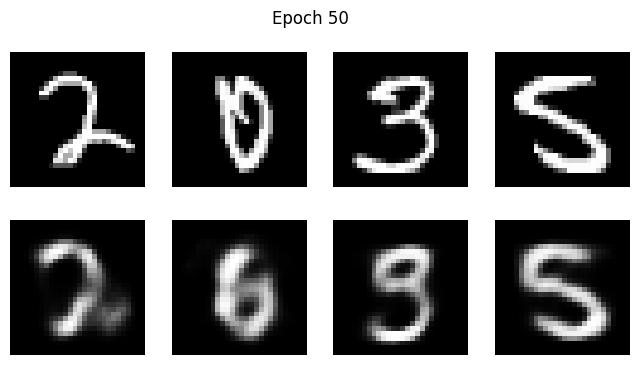

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.9668


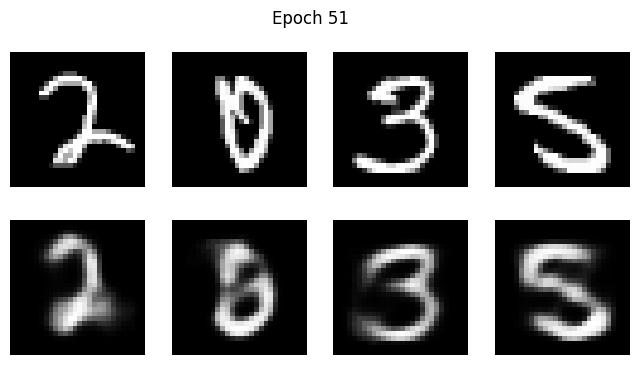

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.9420


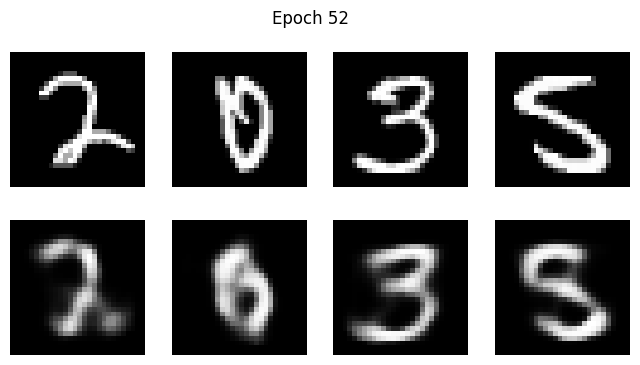

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.9371


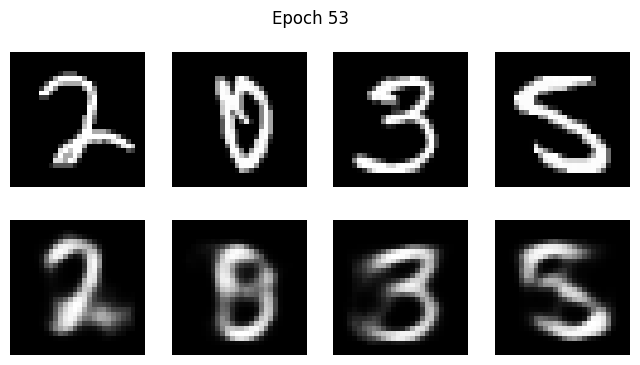

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.8746


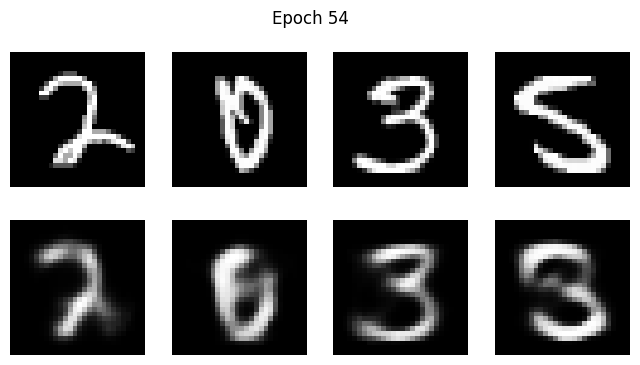

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.8506


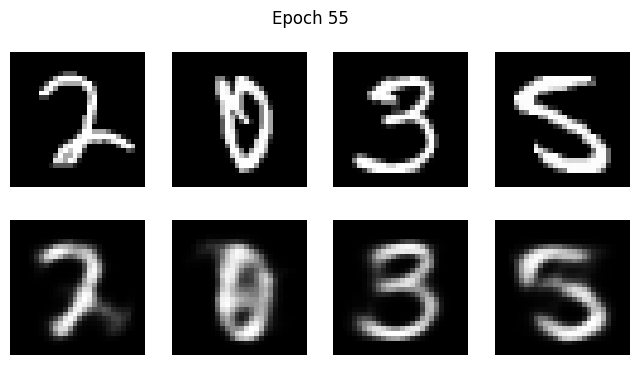

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.8451


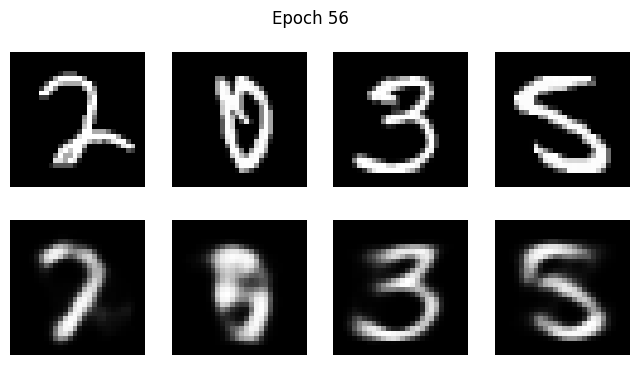

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.8134


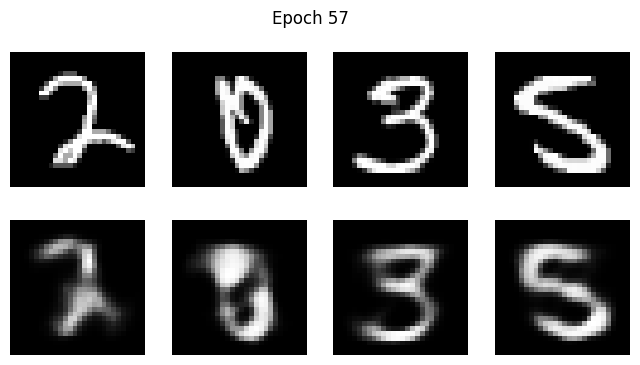

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.7958


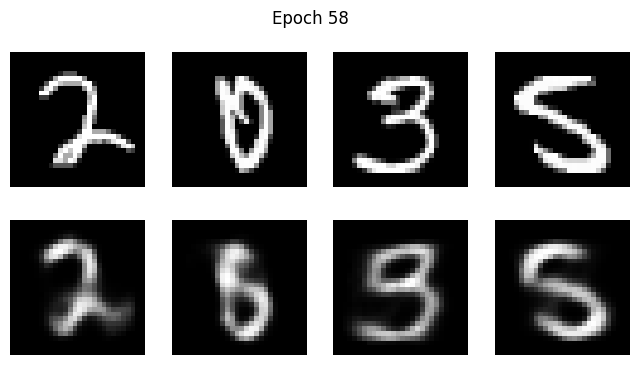

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.7640


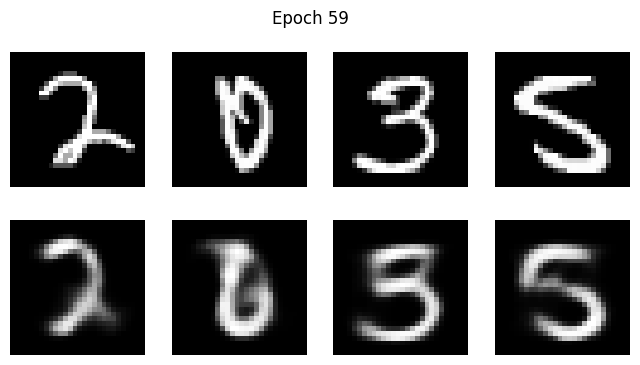

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.7210


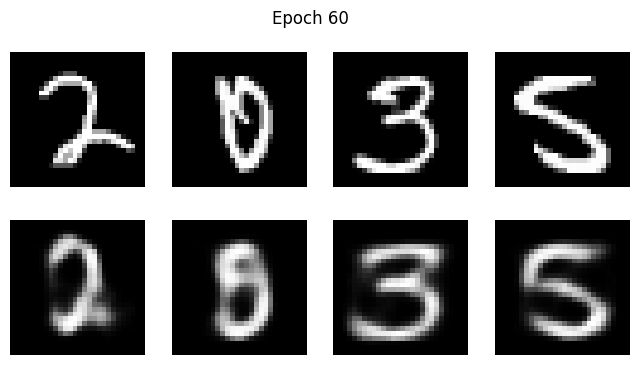

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.7076


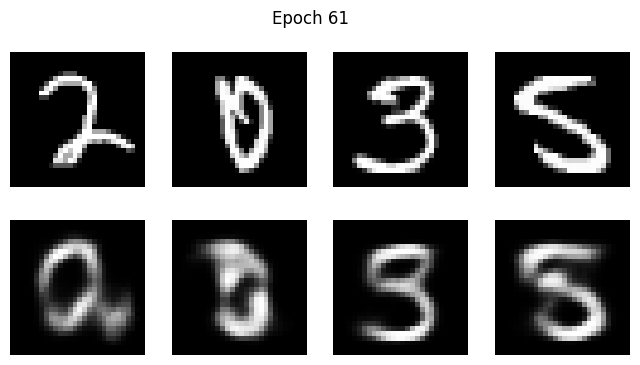

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.6830


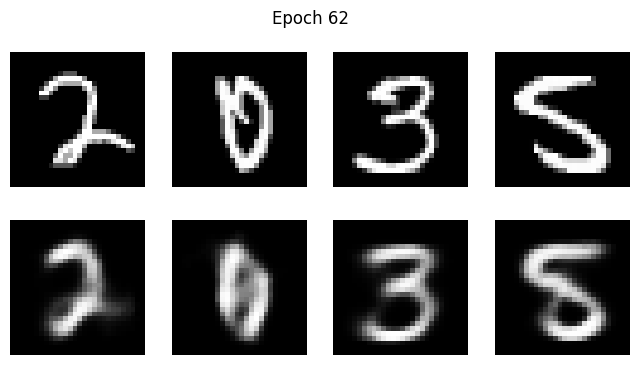

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.6726


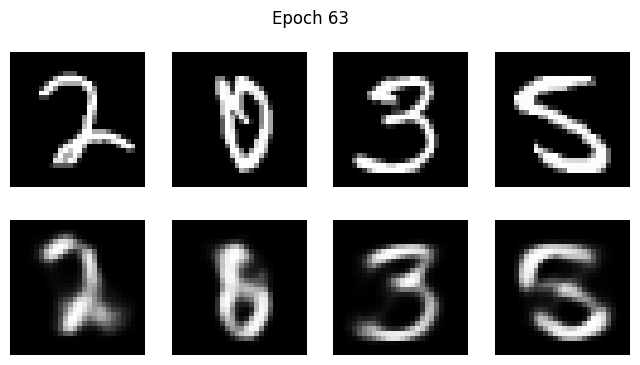

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.6206


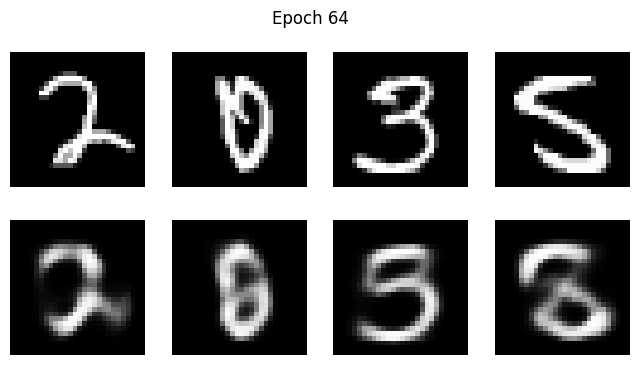

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.6456


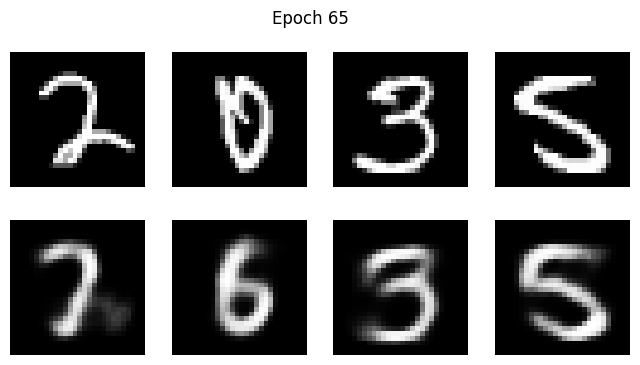

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.5997


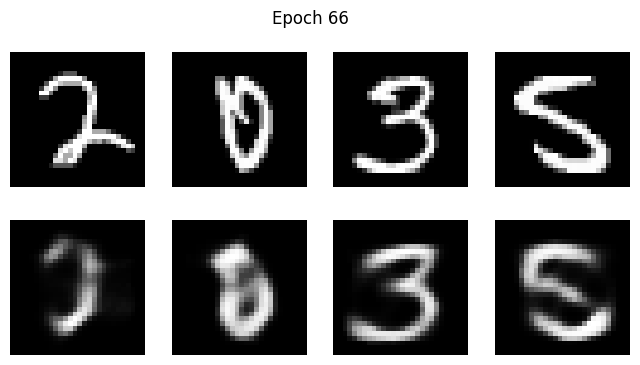

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.5830


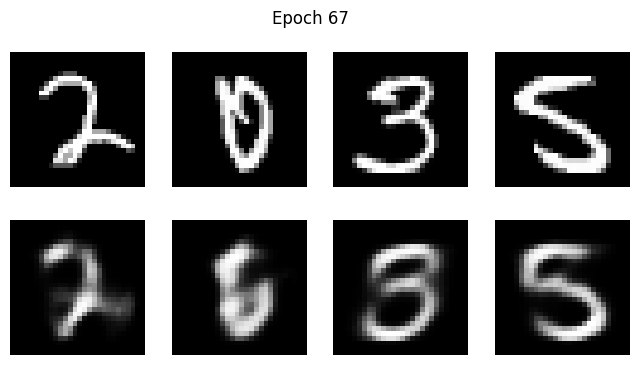

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.5555


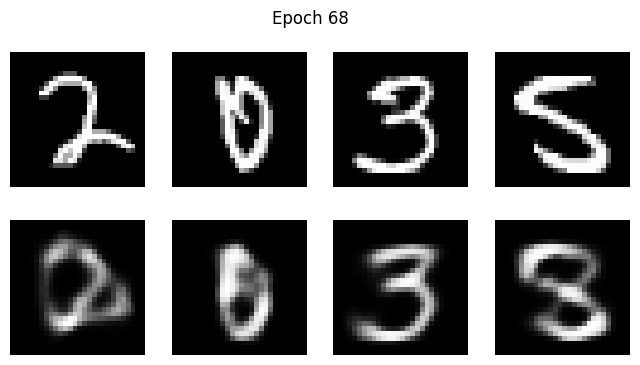

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.5123


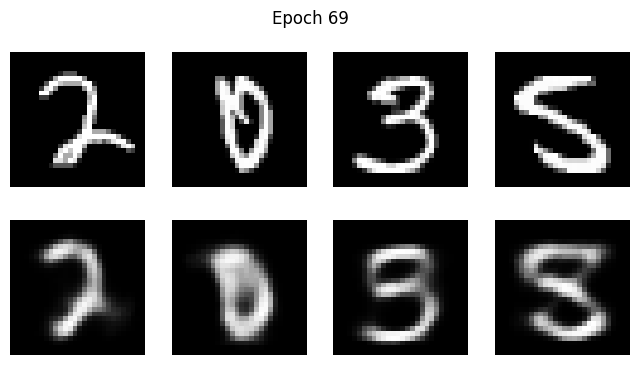

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.5023


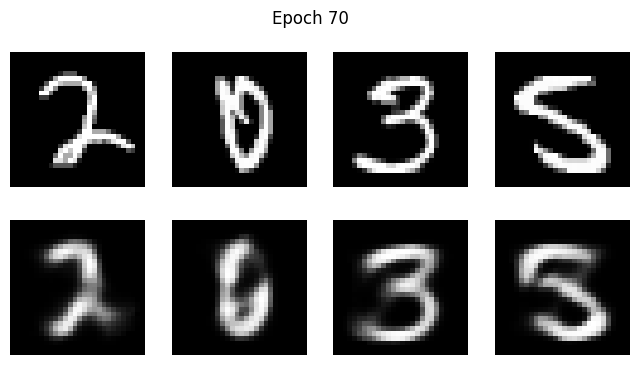

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.5046


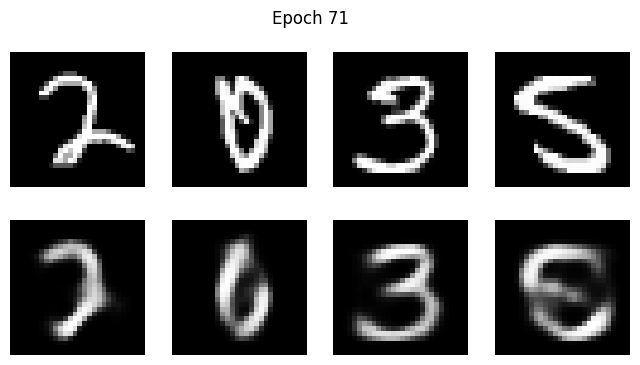

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.4851


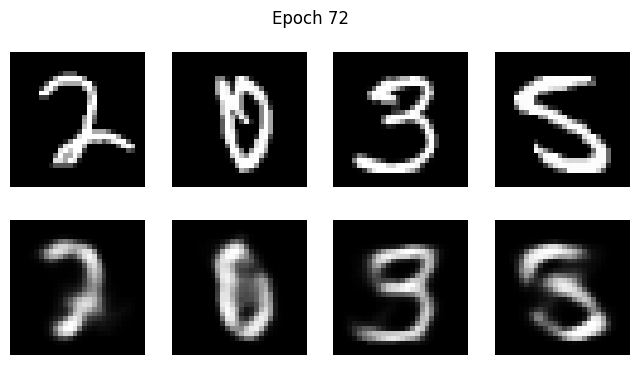

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.4375


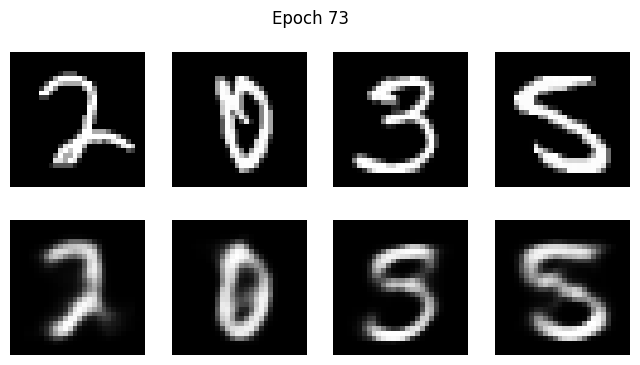

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.4016


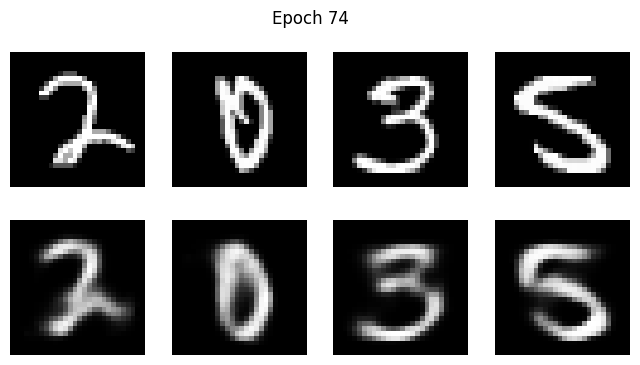

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.4275


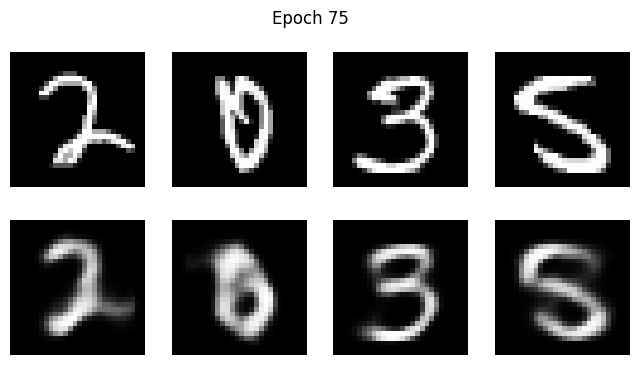

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.3887


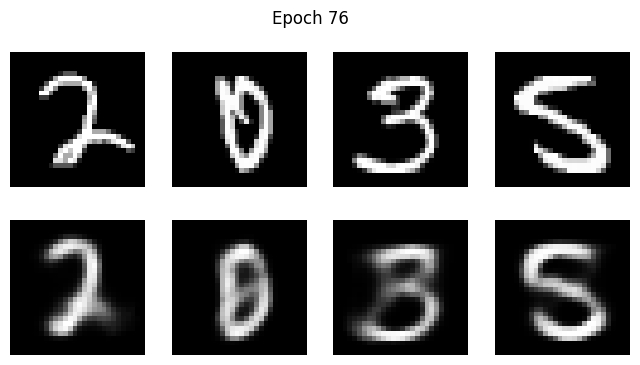

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.4030


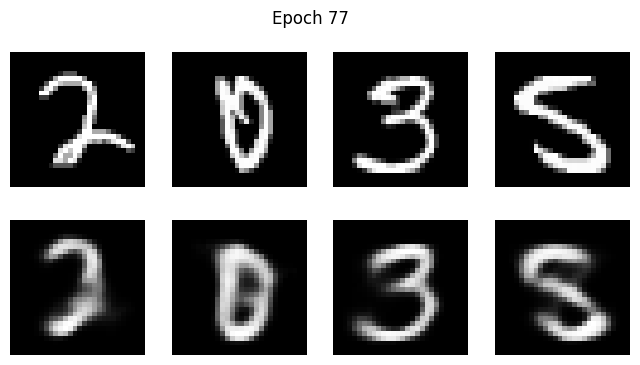

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.3660


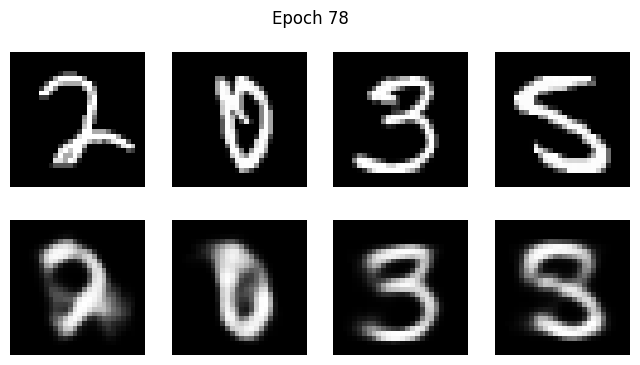

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.3467


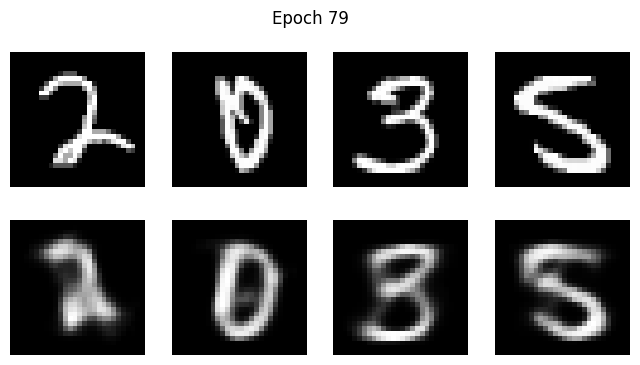

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.3342


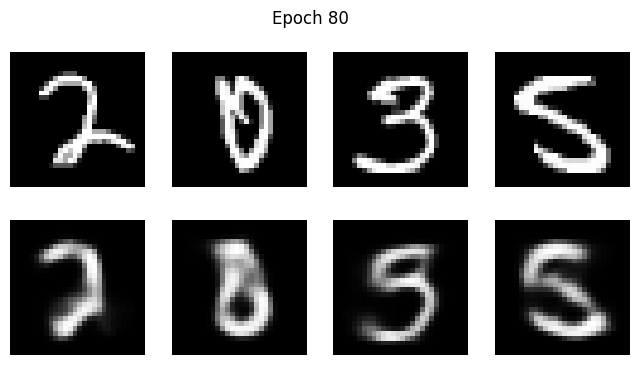

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.3031


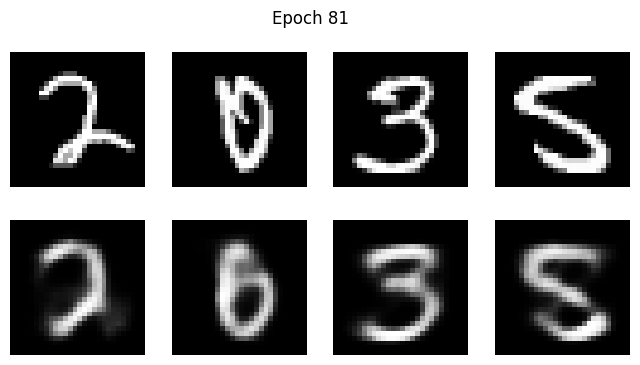

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.3032


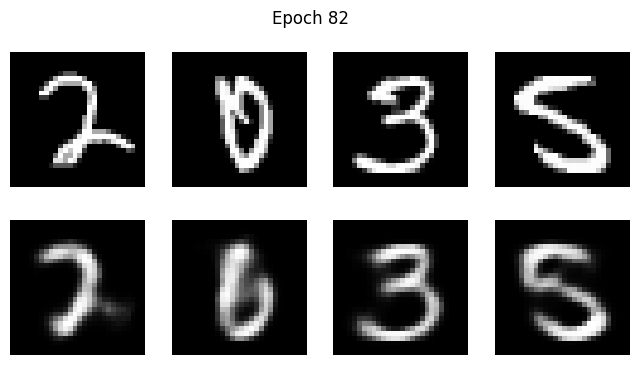

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.2724


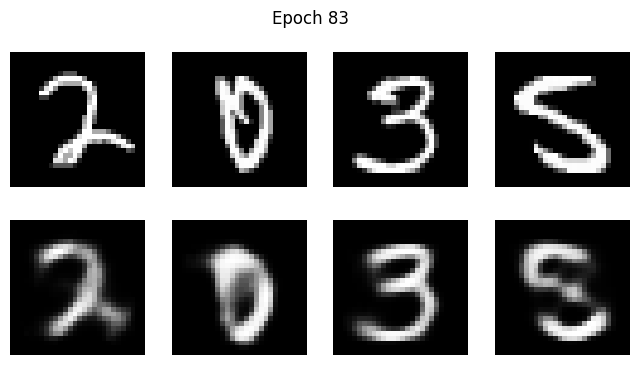

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.3011


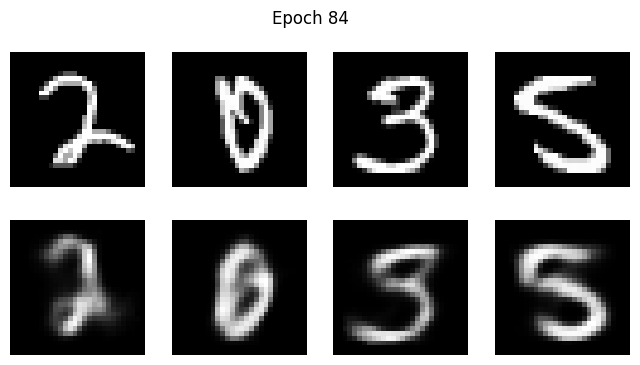

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.2719


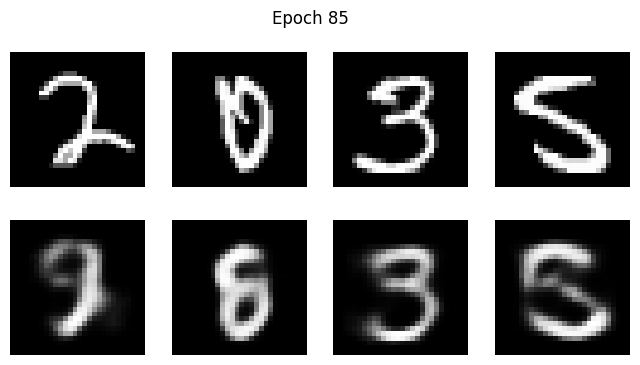

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.2322


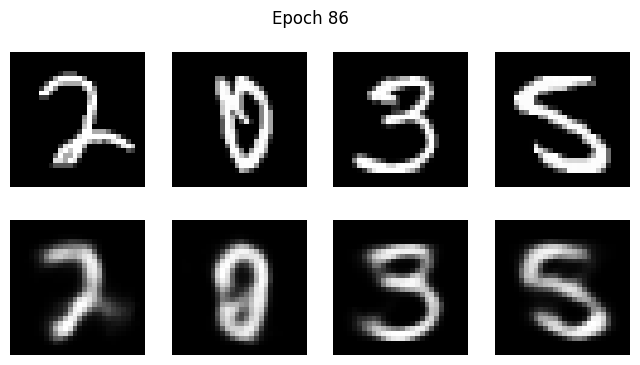

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.2154


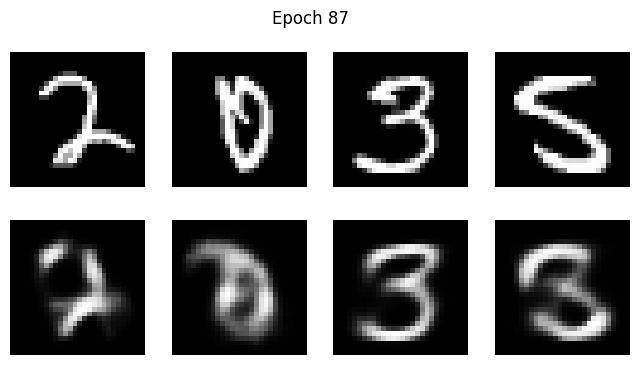

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.2281


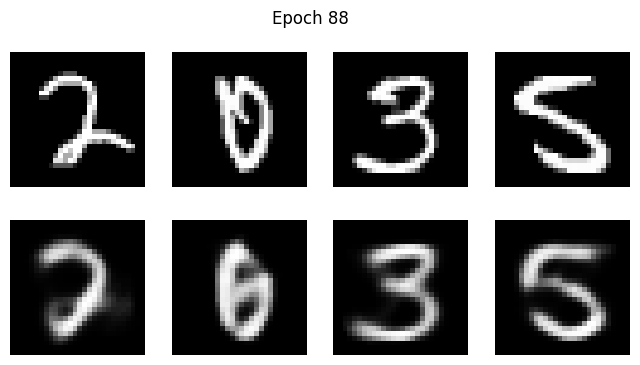

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.2120


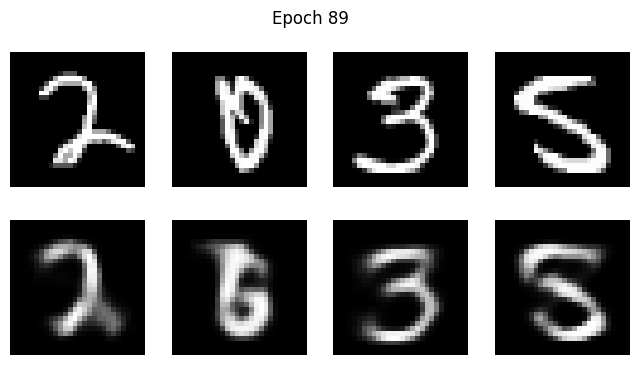

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.1926


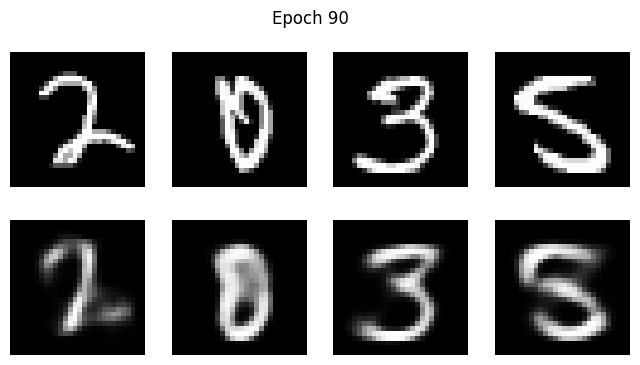

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.1599


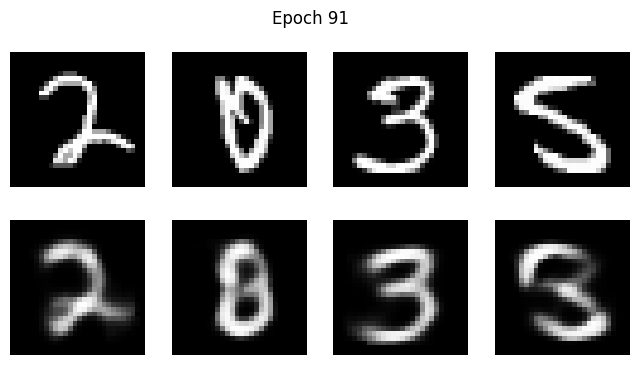

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.1485


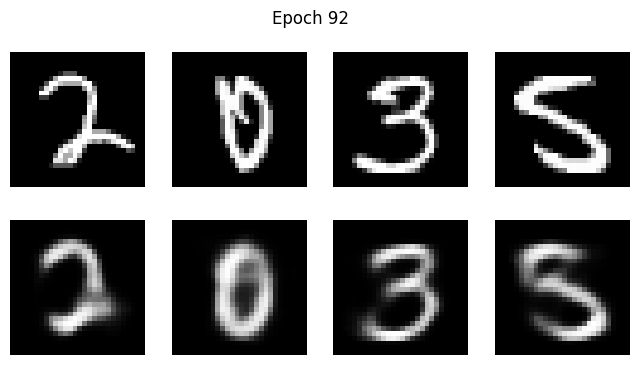

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.1510


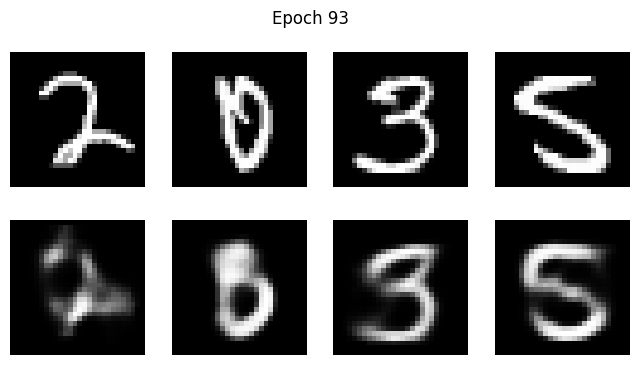

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.1078


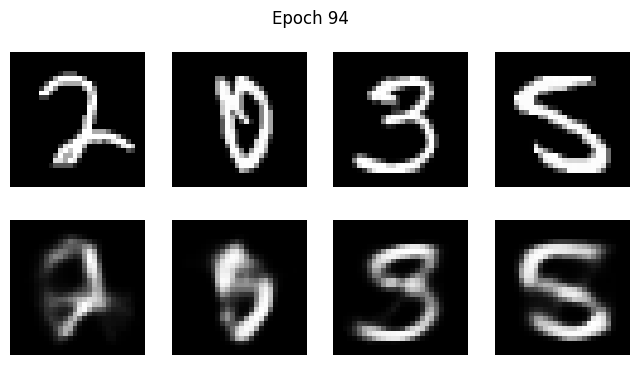

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.1261


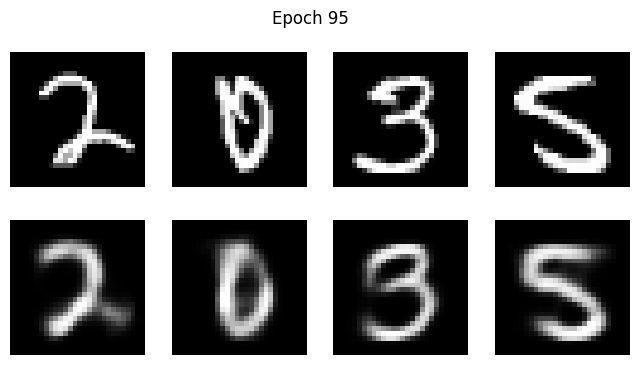

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.0844


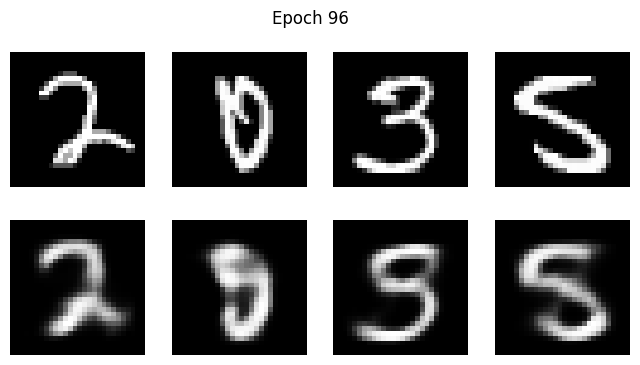

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.0906


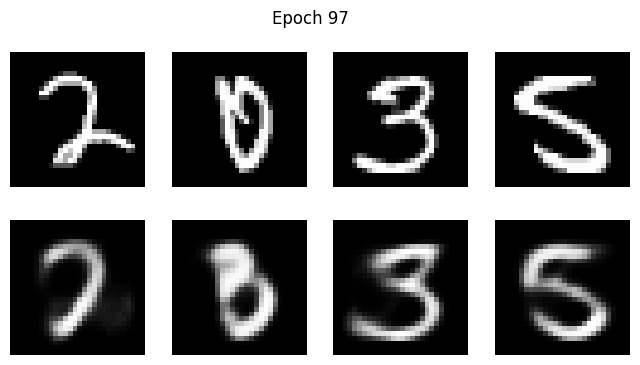

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.1039


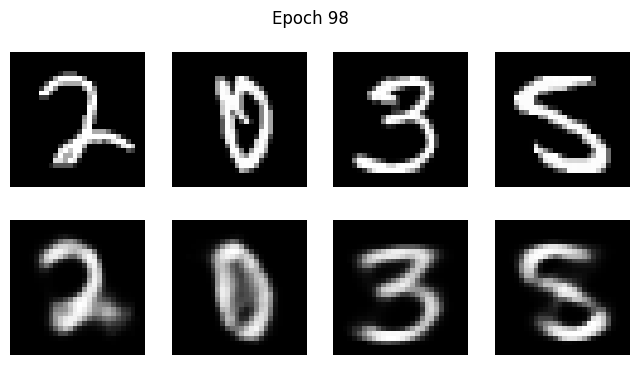

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.0656


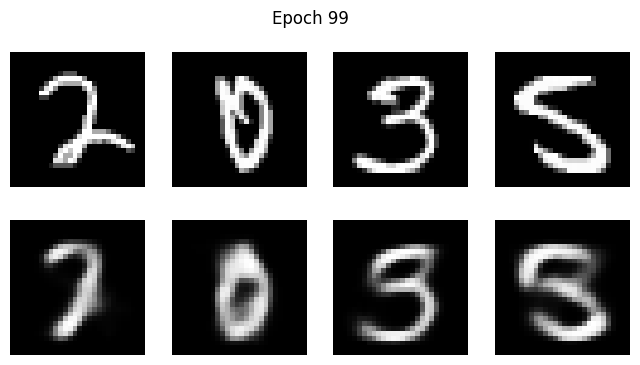

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 30.0708


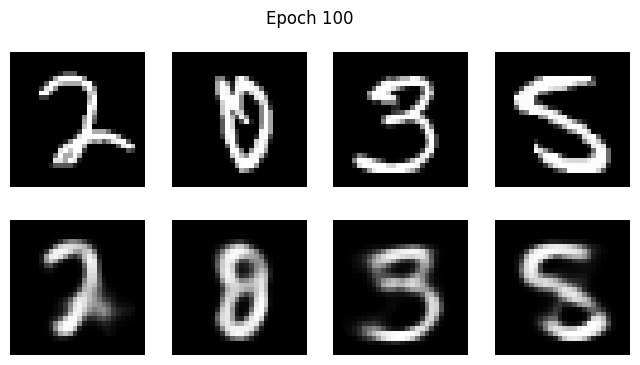

In [27]:
model = train_vae(train_loader, latent_dim=20, hidden_dim=400, input_dim=28*28)

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [61]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        #######################

        self.img_shape = img_shape

        # self.model = nn.Sequential(
        #     nn.Linear(latent_dim, 128),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(128, 256),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(256, 512),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(512, int(torch.prod(torch.tensor(img_shape)))),
        #     nn.Sigmoid()  # Output pixel values between 0 and 1
        # )

        self.model = nn.Sequential(
            nn.Linear(latent_dim,128),
            nn.LeakyReLU(),
            nn.Linear(128,400),
            nn.LeakyReLU(),
            nn.Linear(400,784),
            nn.Tanh()
        )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################

        img_flat = self.model(z)
        img = img_flat.view(z.size(0), *self.img_shape)  # reshape to (batch, channels, 28, 28)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        ###########################

        # self.model = nn.Sequential(
        #     nn.Linear(img_dim, 512),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Linear(512, 256),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Linear(256, 1),
        #     nn.Sigmoid()  # Output probability of real/fake
        # )

        self.model=nn.Sequential(
            nn.Linear(784,400),
            nn.LeakyReLU(),
            nn.Linear(400,128),
            nn.LeakyReLU(),
            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        img_flat = img.view(img.size(0), -1)  # flatten input image
        validity = self.model(img_flat)
        return validity

In [62]:
def train_gan(dataloader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = Generator(latent_dim, img_shape).to(DEVICE)
    discriminator = Discriminator(int(torch.prod(torch.tensor(img_shape)))).to(DEVICE)
    adversarial_loss = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)


    for epoch in range(num_epochs):
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:

                ##########################################################
                # TODO
                # Calculate the loss for the Generator and the Discriminator.
                ##########################################################
                batch_size = imgs.size(0)
                real_imgs = imgs.to(DEVICE)

                # Adversarial ground truths
                valid = torch.ones(batch_size, 1, device=DEVICE)
                fake = torch.zeros(batch_size, 1, device=DEVICE)


                # -----------------
                #  Train Generator
                # -----------------
                optimizer_G.zero_grad()

                # Generator tries to fool discriminator
                z = torch.randn(batch_size, latent_dim, device=DEVICE)
                fake_imgs = generator(z)
                gen_pred = discriminator(fake_imgs)
                g_loss = adversarial_loss(gen_pred, valid)

                g_loss.backward()
                optimizer_G.step()

                # ---------------------
                #  Train Discriminator
                # ---------------------
                optimizer_D.zero_grad()

                # Real images loss
                real_pred = discriminator(real_imgs)
                real_loss = adversarial_loss(real_pred, valid)

                # Fake images loss
                fake_pred = discriminator(fake_imgs.detach())
                fake_loss = adversarial_loss(fake_pred, fake)

                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()


                # TODO
                # Calculate and fill discriminator and generator losses
                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch, num_epochs, d_loss.item(), g_loss.item()))

        # TODO
        # Plot generated images after each epoch
        generator.eval()
        with torch.no_grad():
            sample_z = torch.randn(4, latent_dim, device=DEVICE)
            gen_imgs = generator(sample_z).cpu()
        generator.train()

        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(1, 4, figsize=(8, 2))
        for i in range(4):
            axs[i].imshow(gen_imgs[i].squeeze(), cmap='gray')
            axs[i].axis('off')
        plt.suptitle(f'Generated Images Epoch {epoch+1}')
        plt.show()


    return generator, discriminator

  0%|          | 0/391 [00:00<?, ?it/s]

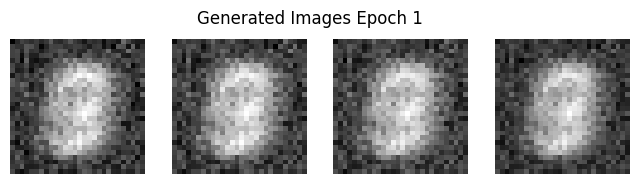

  0%|          | 0/391 [00:00<?, ?it/s]

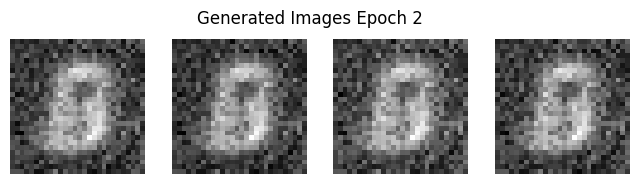

  0%|          | 0/391 [00:00<?, ?it/s]

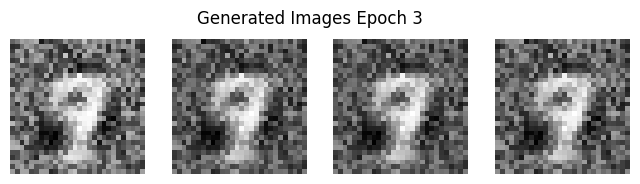

  0%|          | 0/391 [00:00<?, ?it/s]

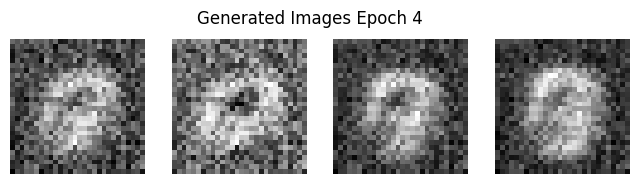

  0%|          | 0/391 [00:00<?, ?it/s]

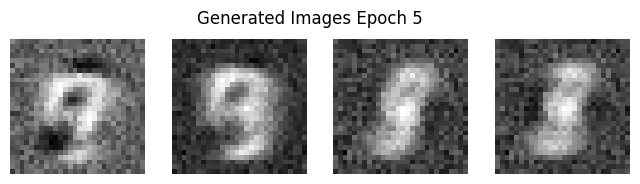

  0%|          | 0/391 [00:00<?, ?it/s]

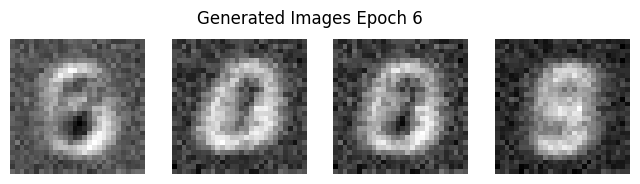

  0%|          | 0/391 [00:00<?, ?it/s]

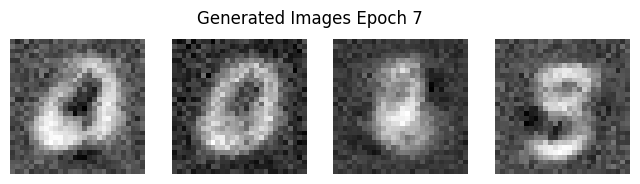

  0%|          | 0/391 [00:00<?, ?it/s]

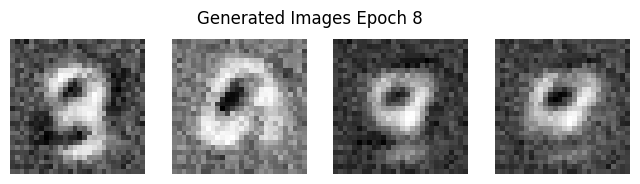

  0%|          | 0/391 [00:00<?, ?it/s]

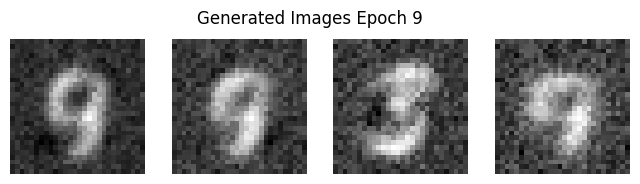

  0%|          | 0/391 [00:00<?, ?it/s]

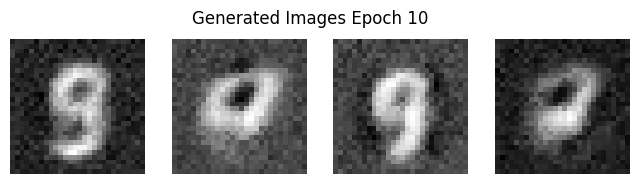

  0%|          | 0/391 [00:00<?, ?it/s]

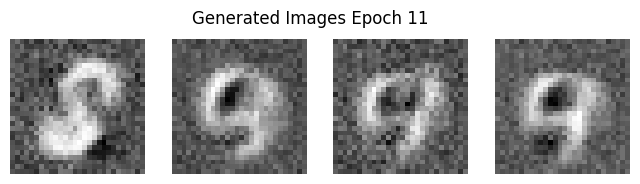

  0%|          | 0/391 [00:00<?, ?it/s]

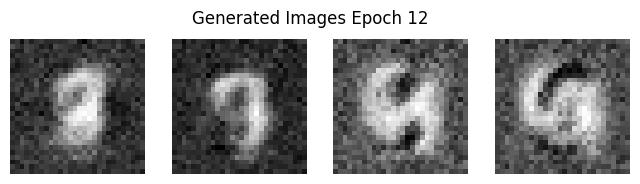

  0%|          | 0/391 [00:00<?, ?it/s]

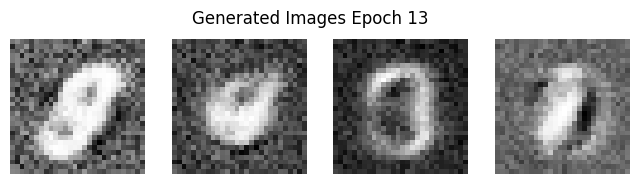

  0%|          | 0/391 [00:00<?, ?it/s]

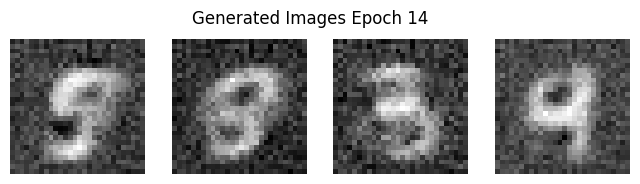

  0%|          | 0/391 [00:00<?, ?it/s]

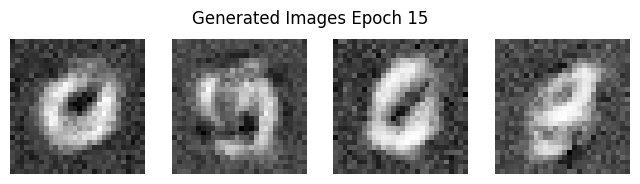

  0%|          | 0/391 [00:00<?, ?it/s]

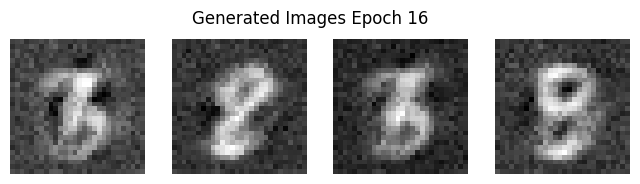

  0%|          | 0/391 [00:00<?, ?it/s]

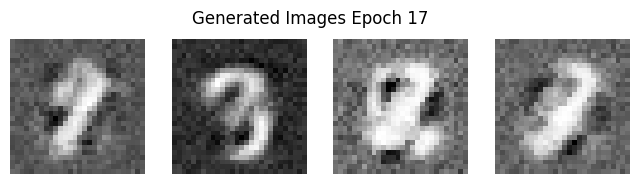

  0%|          | 0/391 [00:00<?, ?it/s]

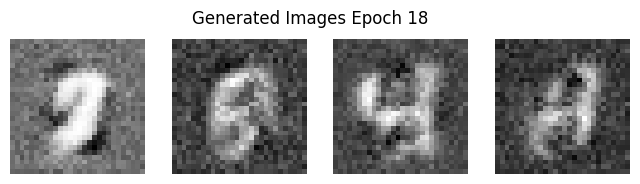

  0%|          | 0/391 [00:00<?, ?it/s]

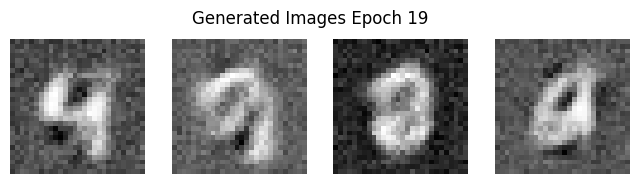

  0%|          | 0/391 [00:00<?, ?it/s]

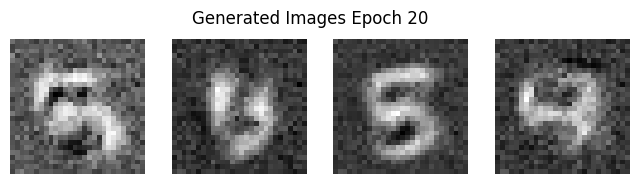

  0%|          | 0/391 [00:00<?, ?it/s]

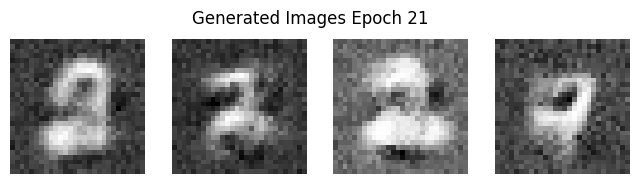

  0%|          | 0/391 [00:00<?, ?it/s]

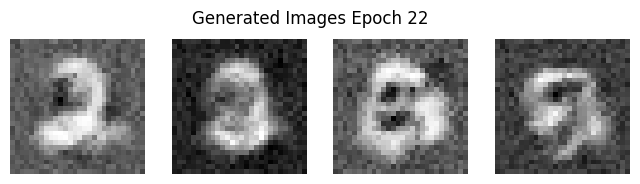

  0%|          | 0/391 [00:00<?, ?it/s]

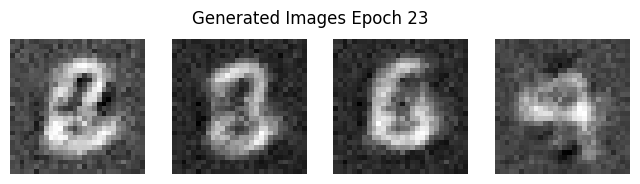

  0%|          | 0/391 [00:00<?, ?it/s]

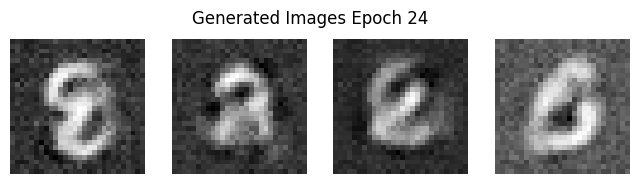

  0%|          | 0/391 [00:00<?, ?it/s]

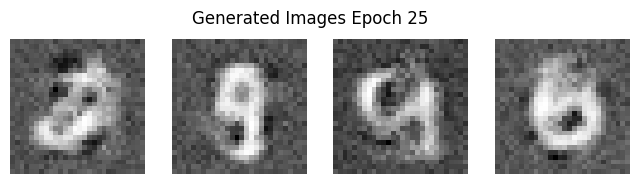

  0%|          | 0/391 [00:00<?, ?it/s]

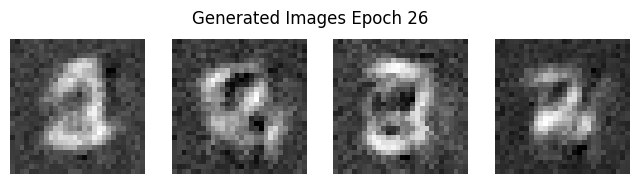

  0%|          | 0/391 [00:00<?, ?it/s]

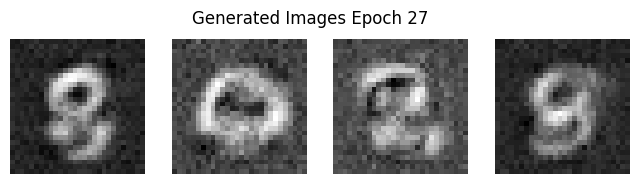

  0%|          | 0/391 [00:00<?, ?it/s]

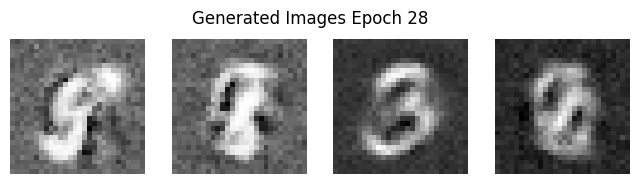

  0%|          | 0/391 [00:00<?, ?it/s]

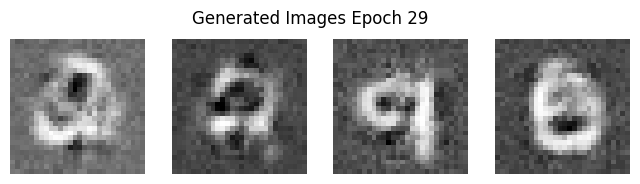

  0%|          | 0/391 [00:00<?, ?it/s]

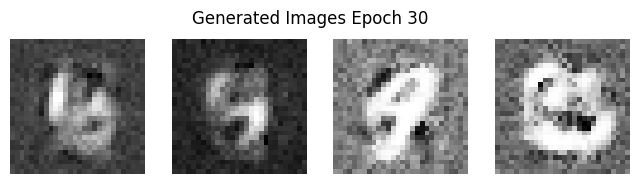

  0%|          | 0/391 [00:00<?, ?it/s]

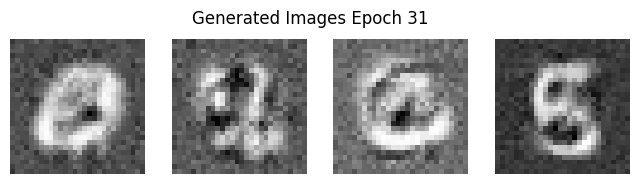

  0%|          | 0/391 [00:00<?, ?it/s]

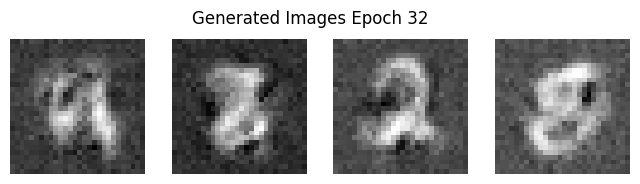

  0%|          | 0/391 [00:00<?, ?it/s]

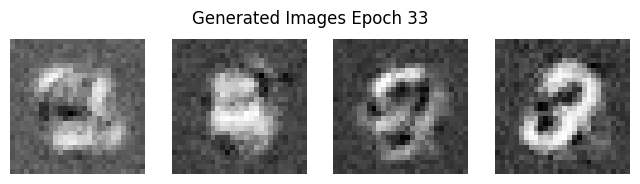

  0%|          | 0/391 [00:00<?, ?it/s]

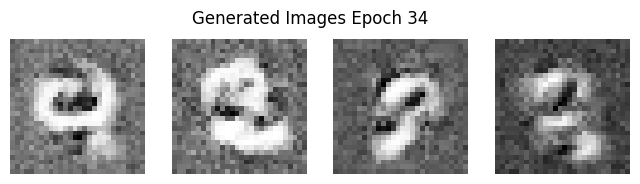

  0%|          | 0/391 [00:00<?, ?it/s]

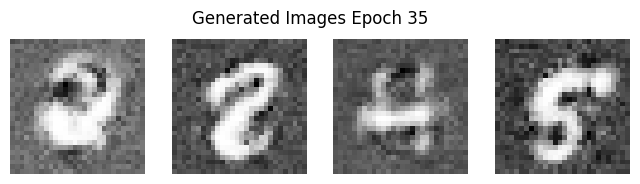

  0%|          | 0/391 [00:00<?, ?it/s]

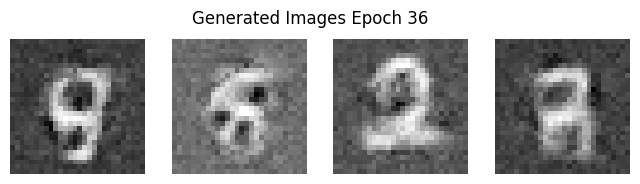

  0%|          | 0/391 [00:00<?, ?it/s]

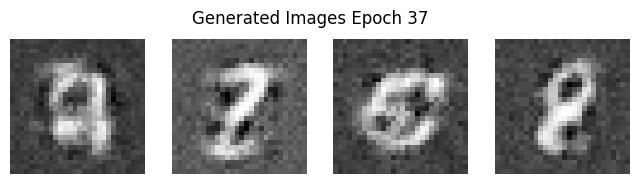

  0%|          | 0/391 [00:00<?, ?it/s]

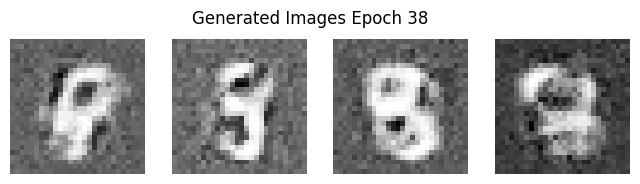

  0%|          | 0/391 [00:00<?, ?it/s]

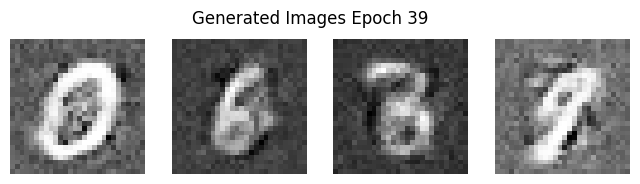

  0%|          | 0/391 [00:00<?, ?it/s]

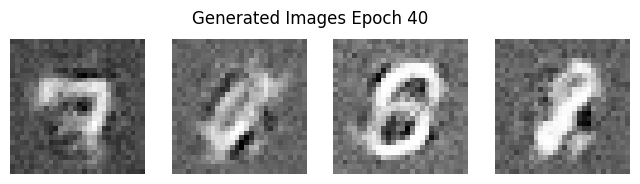

  0%|          | 0/391 [00:00<?, ?it/s]

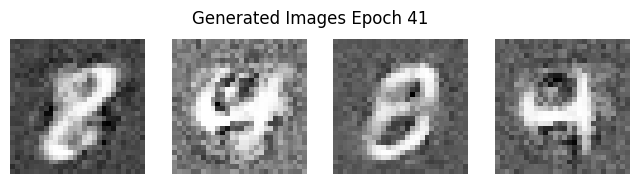

  0%|          | 0/391 [00:00<?, ?it/s]

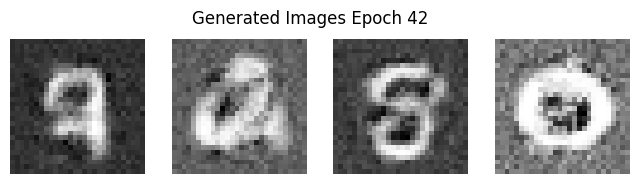

  0%|          | 0/391 [00:00<?, ?it/s]

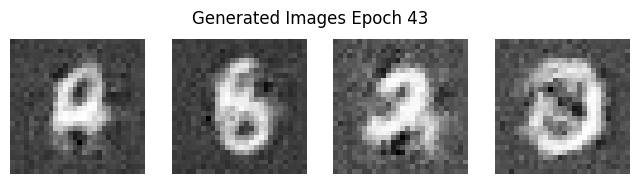

  0%|          | 0/391 [00:00<?, ?it/s]

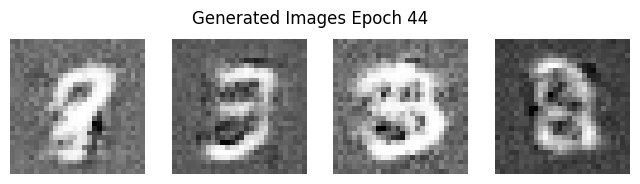

  0%|          | 0/391 [00:00<?, ?it/s]

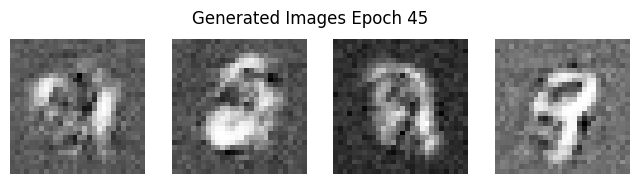

  0%|          | 0/391 [00:00<?, ?it/s]

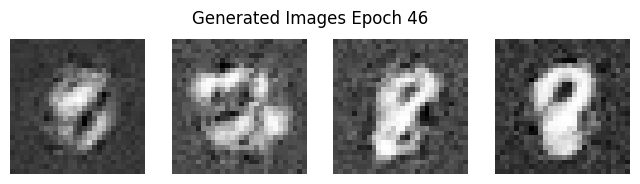

  0%|          | 0/391 [00:00<?, ?it/s]

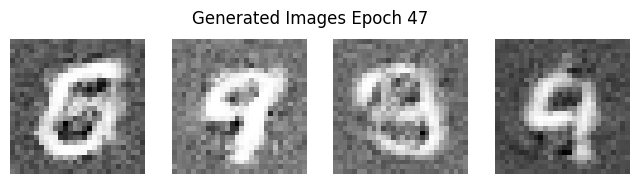

  0%|          | 0/391 [00:00<?, ?it/s]

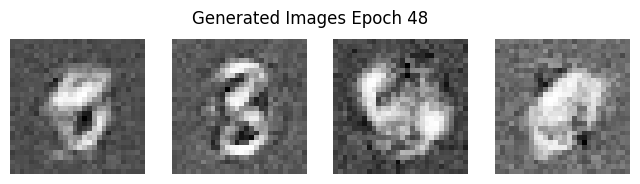

  0%|          | 0/391 [00:00<?, ?it/s]

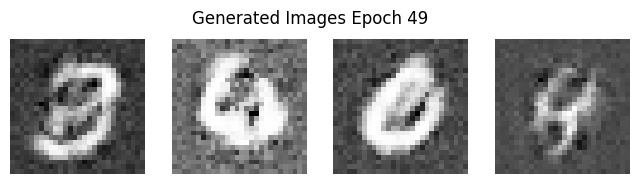

  0%|          | 0/391 [00:00<?, ?it/s]

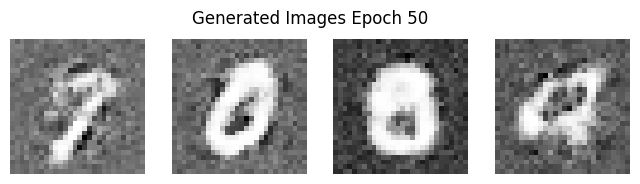

  0%|          | 0/391 [00:00<?, ?it/s]

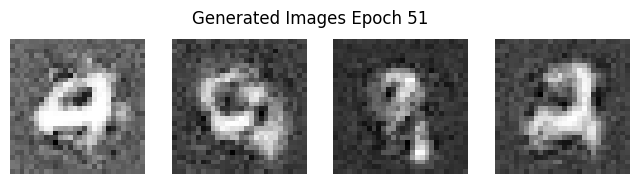

  0%|          | 0/391 [00:00<?, ?it/s]

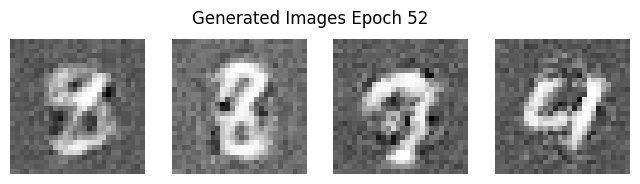

  0%|          | 0/391 [00:00<?, ?it/s]

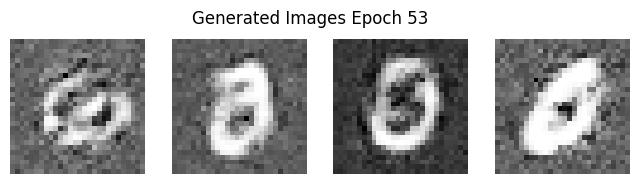

  0%|          | 0/391 [00:00<?, ?it/s]

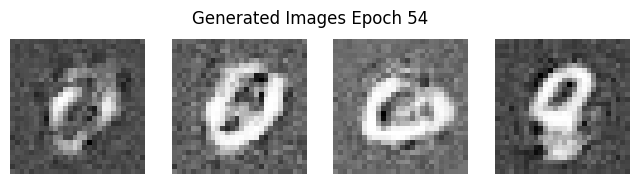

  0%|          | 0/391 [00:00<?, ?it/s]

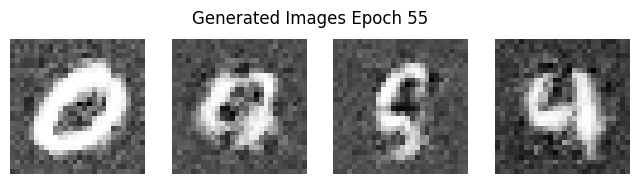

  0%|          | 0/391 [00:00<?, ?it/s]

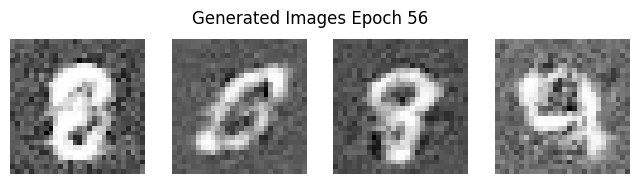

  0%|          | 0/391 [00:00<?, ?it/s]

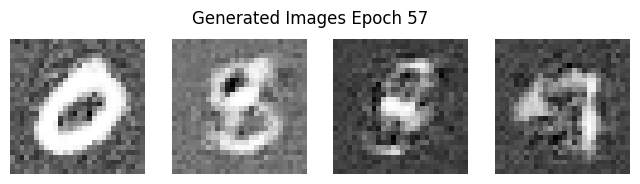

  0%|          | 0/391 [00:00<?, ?it/s]

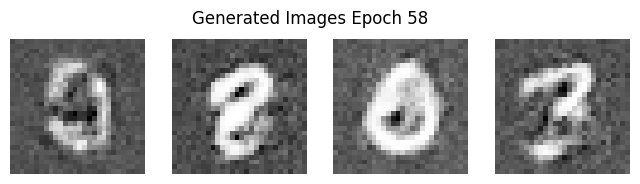

  0%|          | 0/391 [00:00<?, ?it/s]

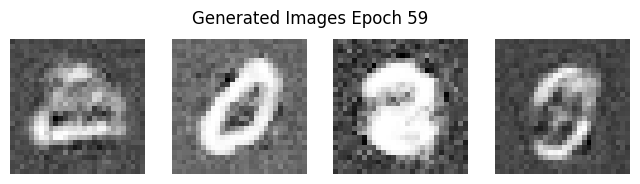

  0%|          | 0/391 [00:00<?, ?it/s]

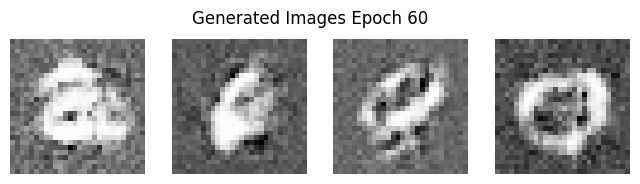

  0%|          | 0/391 [00:00<?, ?it/s]

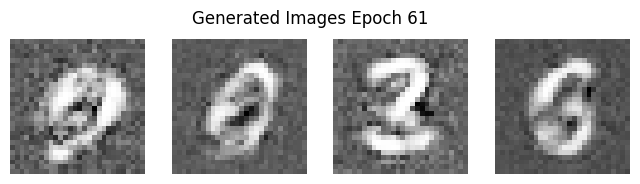

  0%|          | 0/391 [00:00<?, ?it/s]

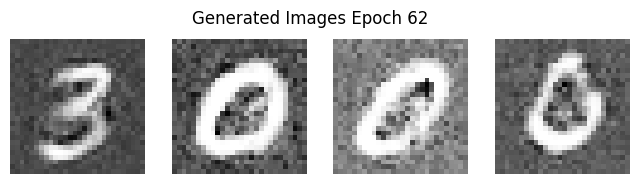

  0%|          | 0/391 [00:00<?, ?it/s]

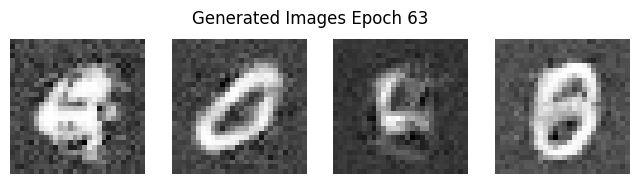

  0%|          | 0/391 [00:00<?, ?it/s]

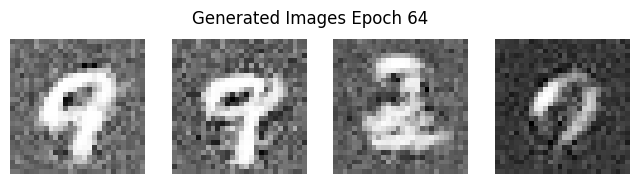

  0%|          | 0/391 [00:00<?, ?it/s]

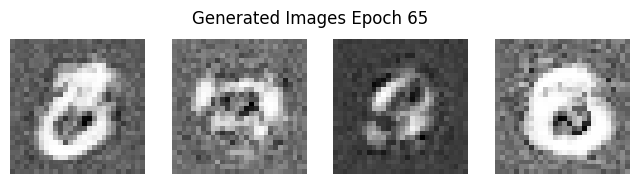

  0%|          | 0/391 [00:00<?, ?it/s]

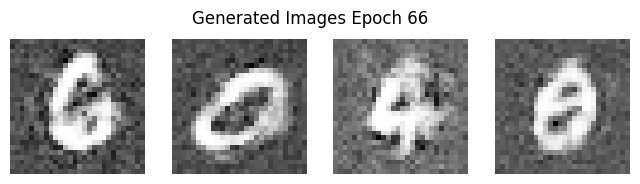

  0%|          | 0/391 [00:00<?, ?it/s]

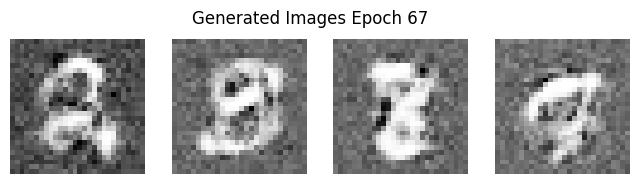

  0%|          | 0/391 [00:00<?, ?it/s]

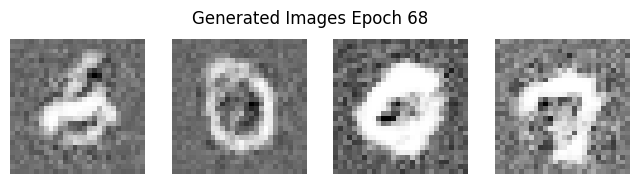

  0%|          | 0/391 [00:00<?, ?it/s]

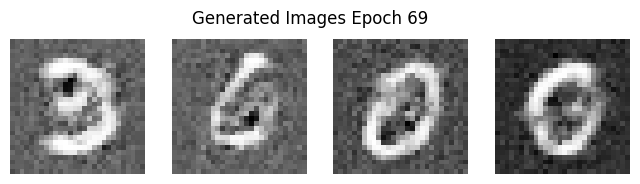

  0%|          | 0/391 [00:00<?, ?it/s]

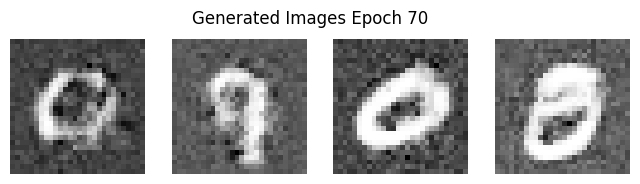

  0%|          | 0/391 [00:00<?, ?it/s]

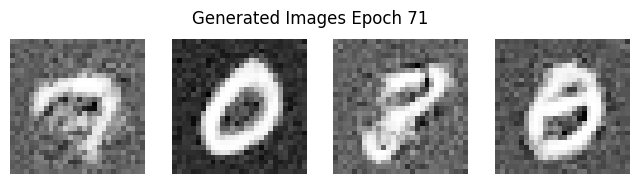

  0%|          | 0/391 [00:00<?, ?it/s]

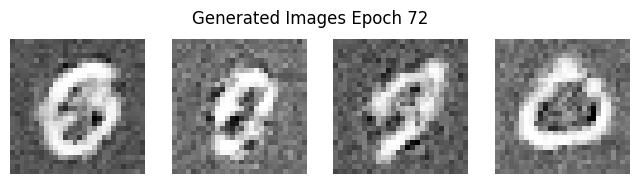

  0%|          | 0/391 [00:00<?, ?it/s]

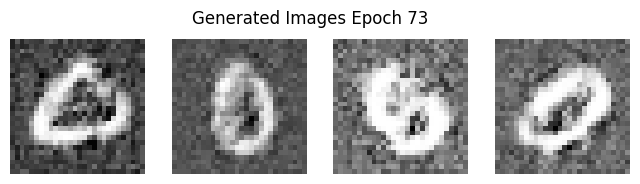

  0%|          | 0/391 [00:00<?, ?it/s]

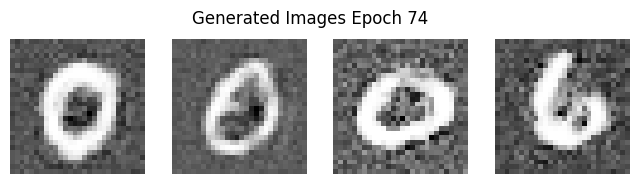

  0%|          | 0/391 [00:00<?, ?it/s]

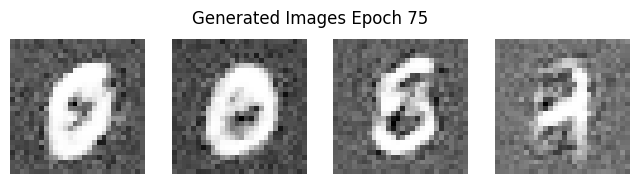

  0%|          | 0/391 [00:00<?, ?it/s]

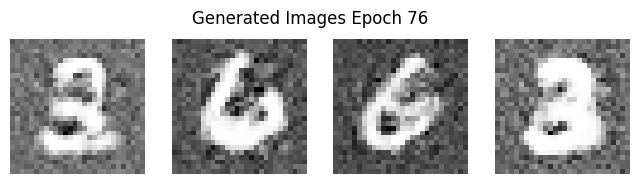

  0%|          | 0/391 [00:00<?, ?it/s]

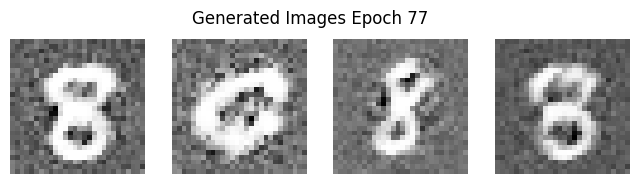

  0%|          | 0/391 [00:00<?, ?it/s]

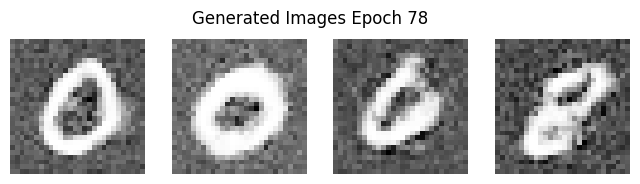

  0%|          | 0/391 [00:00<?, ?it/s]

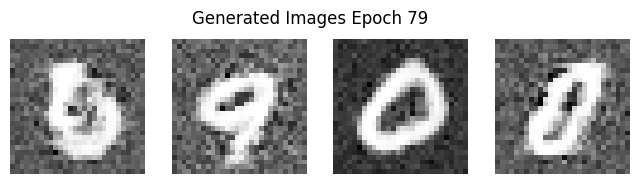

  0%|          | 0/391 [00:00<?, ?it/s]

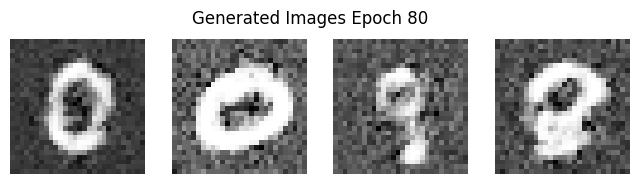

  0%|          | 0/391 [00:00<?, ?it/s]

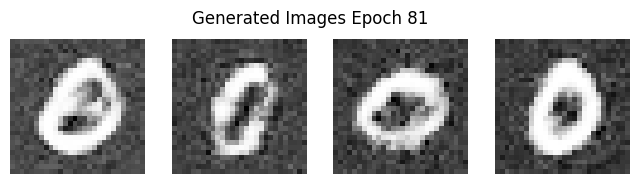

  0%|          | 0/391 [00:00<?, ?it/s]

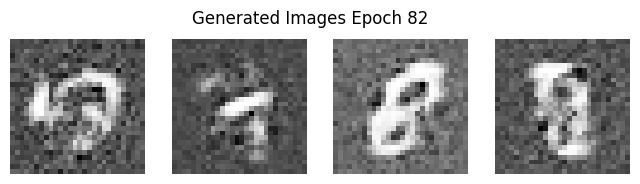

  0%|          | 0/391 [00:00<?, ?it/s]

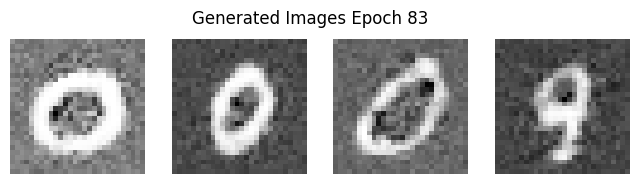

  0%|          | 0/391 [00:00<?, ?it/s]

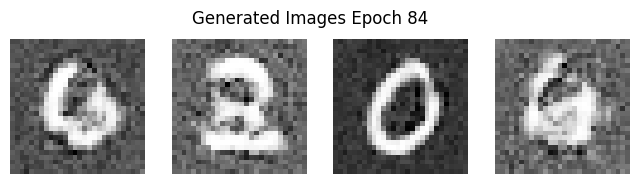

  0%|          | 0/391 [00:00<?, ?it/s]

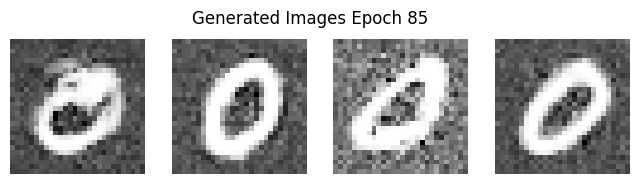

  0%|          | 0/391 [00:00<?, ?it/s]

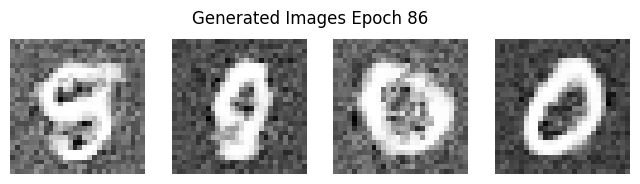

  0%|          | 0/391 [00:00<?, ?it/s]

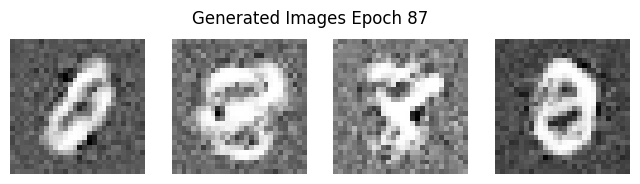

  0%|          | 0/391 [00:00<?, ?it/s]

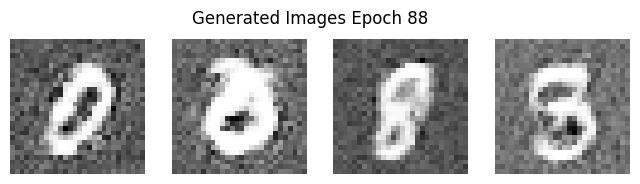

  0%|          | 0/391 [00:00<?, ?it/s]

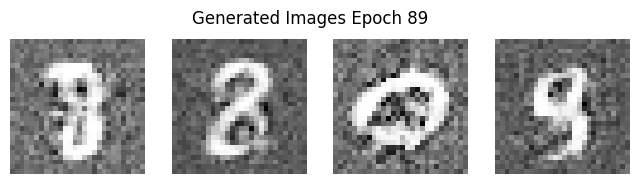

  0%|          | 0/391 [00:00<?, ?it/s]

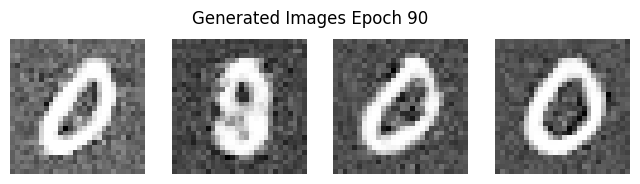

  0%|          | 0/391 [00:00<?, ?it/s]

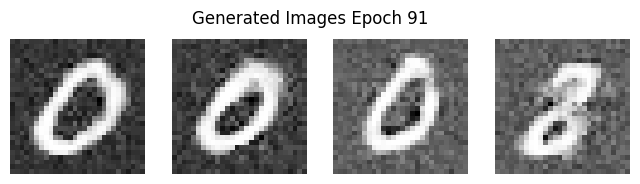

  0%|          | 0/391 [00:00<?, ?it/s]

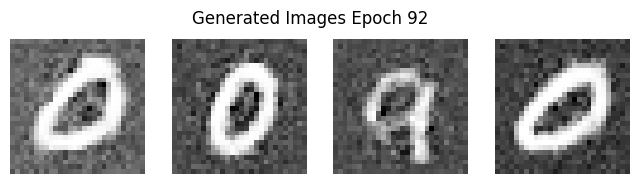

  0%|          | 0/391 [00:00<?, ?it/s]

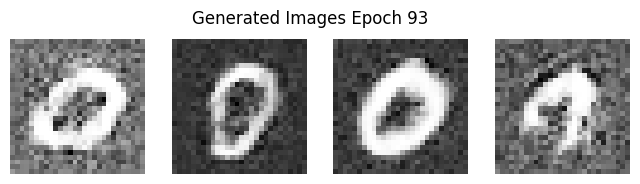

  0%|          | 0/391 [00:00<?, ?it/s]

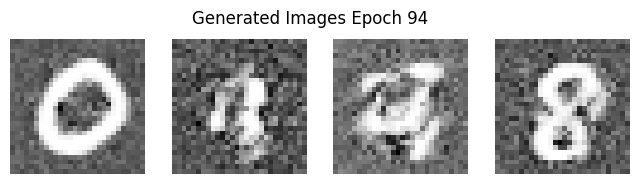

  0%|          | 0/391 [00:00<?, ?it/s]

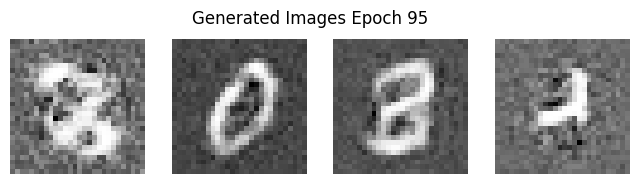

  0%|          | 0/391 [00:00<?, ?it/s]

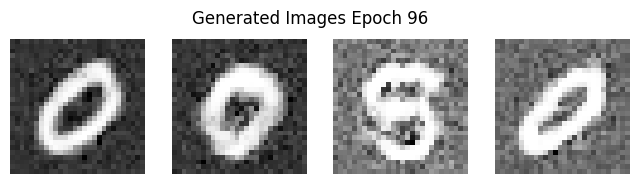

  0%|          | 0/391 [00:00<?, ?it/s]

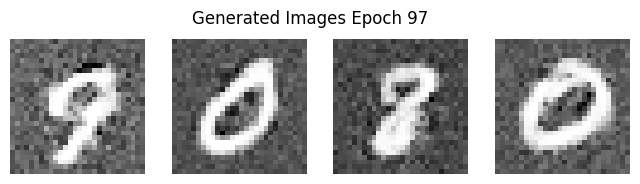

  0%|          | 0/391 [00:00<?, ?it/s]

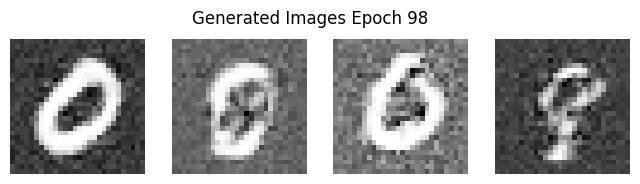

  0%|          | 0/391 [00:00<?, ?it/s]

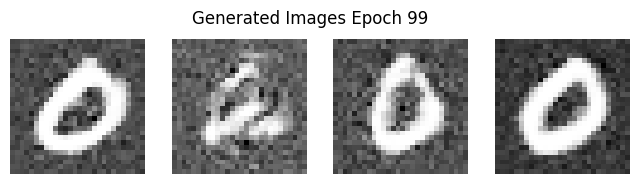

  0%|          | 0/391 [00:00<?, ?it/s]

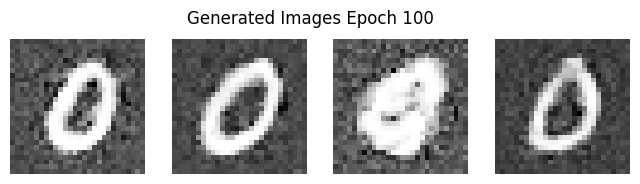

In [63]:
latent_dim=256

generator, discriminator = train_gan(train_loader, latent_dim=latent_dim)

# Compare

Use validation dataset to plot and compare the results of your trained models.

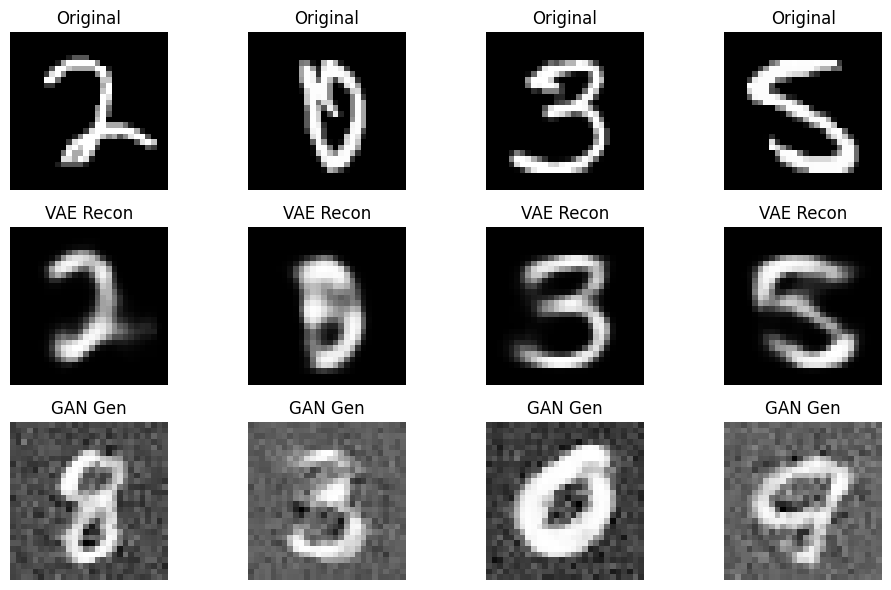

In [78]:
# TODO
# Comparison of the generated images

# Compare
latent_dim=256

model.eval()
generator.eval()

# Get a few validation images
sample_images, _ = next(iter(val_loader))
sample_images = sample_images.to(DEVICE)[:4]

# === VAE Reconstruction ===
with torch.no_grad():
    img, _, _ = model(sample_images)
    recon_images = img.view(-1, 28, 28)

# === GAN Generation ===
with torch.no_grad():
    z = torch.randn(4, latent_dim, device=DEVICE)
    gen_images = generator(z)

# === Plotting ===
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(10, 6))

for i in range(4):
    axs[0, i].imshow(sample_images[i].cpu().squeeze(), cmap='gray')
    axs[0, i].set_title("Original")
    axs[0, i].axis('off')

    axs[1, i].imshow(recon_images[i].cpu().squeeze(), cmap='gray')
    axs[1, i].set_title("VAE Recon")
    axs[1, i].axis('off')

    axs[2, i].imshow(gen_images[i].cpu().squeeze(), cmap='gray')
    axs[2, i].set_title("GAN Gen")
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()
